# Telecom Churn Case Study

## Problem Statement

### Business problem overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

#### Understanding and defining churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.

#### Definitions of churn
There are various ways to define churn, such as:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, you will use the usage-based definition to define churn.

#### High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

#### Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

#### Understanding customer behaviour during churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Importing libraries.

In [1]:
#Importing neccesary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time

# Supressing the warnings generated
import warnings
warnings.filterwarnings('ignore')

# Importing Pandas EDA tool
import pandas_profiling as pp
from pandas_profiling import ProfileReport

# Displaying all Columns without restrictions
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from sklearn.metrics import confusion_matrix
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### IMPORTING DATA.

In [2]:
# reading the data file.
tc=pd.read_csv('telecom_churn_data.csv')

In [3]:
# looking some data using head command
tc.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  7000842753     109        0.0             0.0             0.0              
1  7001865778     109        0.0             0.0             0.0              
2  7001625959     109        0.0             0.0             0.0              
3  7001204172     109        0.0             0.0             0.0              
4  7000142493     109        0.0             0.0             0.0              

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0  6/30/2014            7/31/2014            8/31/2014             
1  6/30/2014            7/31/2014            8/31/2014             
2  6/30/2014            7/31/2014            8/31/2014             
3  6/30/2014            7/31/2014            8/31/2014             
4  6/30/2014            7/31/2014            8/31/2014             

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0  9/30/2014            197.385  214.816  213.803  21.100  NaN            
1  9/30/2014            34.047   355.074  268.321  86.285   24.11         
2  9/30/2014            167.690  189.058  210.226  290.714  11.54         
3  9/30/2014            221.338  251.102  508.054  389.500  99.91         
4  9/30/2014            261.636  309.876  238.174  163.426  50.31         

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0 NaN           0.00        NaN          NaN           NaN             
1  78.68        7.68         18.34        15.74         99.84          
2  55.24        37.26        74.81        143.33        220.59         
3  54.39        310.98       241.71       123.31        109.01         
4  149.44       83.89        58.78        76.96         91.88          

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0  0.00         NaN           NaN            NaN             0.00            
1  304.76        53.76         0.0            0.00           0.00            
2  208.36        118.91        0.0            0.00           0.00            
3  71.68         113.54        0.0            54.86          44.38           
4  124.26        45.81         0.0            0.00           0.00            

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0 NaN            NaN            NaN             0.00          NaN              
1  0.00           0.0            0.00           0.00           0.00            
2  38.49          0.0            0.00           0.00           70.94           
3  0.00           0.0            28.09          39.04          0.00            
4  0.00           0.0            0.00           0.00           0.00            

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  23.88             74.56             7.68              18.34              
2  7.19              28.74             13.58             14.39              
3  73.68             34.81             10.61             15.49              
4  50.31             149.44            83.89             58.78              

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  11.51             75.94             291.86            53.76              
2  29.34             16.86             38.46             28.16              
3  107.43            83.21             22.46             65.46              
4  67.64             91.88             124.26            37.89              

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  0.00              0.00              0.00              0.00               
2  24.11             21.79             15.61             22.24              
3  1.91              0.65              4.91        

* These are some insight of the data.
* Data contains lots of columns and rows.


In [4]:
# Look into the types of data by using info command
tc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

It can be seen that there are 99999 rows and 226 colum present in our data.

In [5]:
# Now, describing the the data.
tc.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  9.999900e+04   99999.0    98981.0         98981.0          
mean   7.001207e+09   109.0      0.0             0.0              
std    6.956694e+05   0.0        0.0             0.0              
min    7.000000e+09   109.0      0.0             0.0              
25%    7.000606e+09   109.0      0.0             0.0              
50%    7.001205e+09   109.0      0.0             0.0              
75%    7.001812e+09   109.0      0.0             0.0              
max    7.002411e+09   109.0      0.0             0.0              

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count  98981.0         99999.000000  99999.000000  99999.000000  99999.000000   
mean   0.0             282.987358    278.536648    279.154731    261.645069     
std    0.0             328.439770    338.156291    344.474791    341.998630     
min    0.0            -2258.709000  -2014.045000  -945.808000   -1899.505000    
25%    0.0             93.411500     86.980500     84.126000     62.685000      
50%    0.0             197.704000    191.640000    192.080000    176.849000     
75%    0.0             371.060000    365.344500    369.370500    353.466500     
max    0.0             27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean   132.395875    133.670805    133.018098    130.302327    197.935577     
std    297.207406    308.794148    308.951589    308.477668    316.851613     
min    0.000000      0.000000      0.000000      0.000000      0.000000       
25%    7.380000      6.660000      6.460000      5.330000      34.730000      
50%    34.310000     32.330000     32.360000     29.840000     96.310000      
75%    118.740000    115.595000    115.860000    112.130000    231.860000     
max    7376.710000   8157.780000   10752.560000  10427.460000  8362.360000    

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000  96062.000000   96140.000000    
mean   197.045133    196.574803    190.337222    9.950013       7.149898        
std    325.862803    327.170662    319.396092    72.825411      73.447948       
min    0.000000      0.000000      0.000000      0.000000       0.000000        
25%    32.190000     31.630000     27.130000     0.000000       0.000000        
50%    91.735000     92.140000     87.290000     0.000000       0.000000        
75%    226.815000    228.260000    220.505000    0.000000       0.000000        
max    9667.130000   14007.340000  10310.760000  13724.380000   15371.040000    

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count  94621.000000   92254.000000   96062.000000   96140.000000    
mean   7.292981       6.343841       13.911337      9.818732        
std    68.402466      57.137537      71.443196      58.455762       
min    0.000000       0.000000       0.000000       0.000000        
25%    0.000000       0.000000       0.000000       0.000000        
50%    0.000000       0.000000       0.000000       0.000000        
75%    0.000000       0.000000       0.000000       0.000000        
max    13095.360000   8464.030000    3775.110000    2812.040000     

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count  94621.000000   92254.000000   96062.000000      96140.000000       
mean   9.971890       8.555519       47.100763         46.473010          
std    64.713221      58.438186      150.856393        155.318705         
min    0.000000       0.000000       0.000000          0.000000           
25%    0.000000       0.000000       1.660000          1.630000           
50%    0.000000       0.000000       11.910000         11.610000          
75%    0.000000       0.000000       40.960000         39.910000          
max    53

This is the initial analysis of the data.

### Importing data dictionary for understanding the terms.

In [6]:
# Importing data dictioary file
data_dictionary= pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')

In [7]:
# Looking into the excel file.
data_dictionary

Acronyms      \
0   MOBILE_NUMBER   
1   CIRCLE_ID       
2   LOC             
3   STD             
4   IC              
5   OG              
6   T2T             
7   T2M             
8   T2O             
9   T2F             
10  T2C             
11  ARPU            
12  MOU             
13  AON             
14  ONNET           
15  OFFNET          
16  ROAM            
17  SPL             
18  ISD             
19  RECH            
20  NUM             
21  AMT             
22  MAX             
23  DATA            
24  3G              
25  AV              
26  VOL             
27  2G              
28  PCK             
29  NIGHT           
30  MONTHLY         
31  SACHET          
32  *.6             
33  *.7             
34  *.8             
35  *.9             
36  FB_USER         
37  VBC             

                                                                          Descriptions  
0   Customer phone number                                                               
1   Telecom circle area to which the customer belongs to                                
2   Local calls - within same telecom circle                                            
3   STD calls - outside the calling circle                                              
4   Incoming calls                                                                      
5   Outgoing calls                                                                      
6   Operator T to T, i.e. within same operator (mobile to mobile)                       
7   Operator T to other operator mobile                                                 
8   Operator T to other operator fixed line                                             
9   Operator T to fixed lines of T                                                      
10  Operator T to it’s own call center                                                  
11  Average revenue per user                                                            
12  Minutes of usage - voice calls                                                      
13  Age on network - number of days the customer is using the operator T network        
14  All kind of calls within the same operator network                                  
15  All kind of calls outside the operator T network                                    
16  Indicates that customer is in roaming zone during the call                          
17  Special calls                                                                       
18  ISD calls                                                                           
19  Recharge                                                                            
20  Number                                                                              
21  Amount in local currency                                                            
22  Maximum                                                                             
23  Mobile internet                                                                     
24  3G network                                                                          
25  Average                                                                             
26  Mobile internet usage volume (in MB)                                                
27  2G network                                                                          
28  Prepaid service schemes called - PACKS                                              
29  Scheme to use during specific night hours only                                      
30  Service schemes with validity equivalent to a month                                 
31  Service schemes with validity smaller than a month                                  
32  KPI for the month of June                                                           
33  KPI for the month of July                                                           
34  KPI for the month of August                                       

Dictionary file gives description about various columns which will be helpful in understanding data.

### DATA CLEANING.

In [8]:
# Check the columnsfor unique values and drop these columns with its value as 1
unique=[]
for i in tc.columns:
    if tc[i].nunique() == 1:
        unique.append(i)
    else:
        pass

tc.drop(unique, axis=1, inplace = True)
print( unique)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


#### As these columns have unique values so, they are dropped from the data set.


In [9]:
# check for shape of dataframe.
tc.shape

(99999, 210)

#### Earlier 226 columns were present now after dropping these columns 210 columns remaining in the dataset.

In [10]:
# Checking for null values in data set.
((tc.isnull().sum()/tc.shape[0])*100).round(2).sort_values(ascending=False)

night_pck_user_6            74.85
arpu_2g_6                   74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
count_rech_2g_6             74.85
max_rech_data_6             74.85
fb_user_6                   74.85
date_of_last_rech_data_6    74.85
total_rech_data_6           74.85
arpu_3g_6                   74.85
night_pck_user_7            74.43
arpu_2g_7                   74.43
total_rech_data_7           74.43
arpu_3g_7                   74.43
max_rech_data_7             74.43
av_rech_amt_data_7          74.43
count_rech_3g_7             74.43
date_of_last_rech_data_7    74.43
count_rech_2g_7             74.43
fb_user_7                   74.43
date_of_last_rech_data_9    74.08
arpu_2g_9                   74.08
max_rech_data_9             74.08
count_rech_3g_9             74.08
fb_user_9                   74.08
av_rech_amt_data_9          74.08
total_rech_data_9           74.08
arpu_3g_9                   74.08
count_rech_2g_9             74.08
night_pck_user

#### There are lots of null values present in the data set.
#### We have to further handle these columns.

In [11]:
# Looking for types of dataset.
tc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   arpu_6                    float64
 2   arpu_7                    float64
 3   arpu_8                    float64
 4   arpu_9                    float64
 5   onnet_mou_6               float64
 6   onnet_mou_7               float64
 7   onnet_mou_8               float64
 8   onnet_mou_9               float64
 9   offnet_mou_6              float64
 10  offnet_mou_7              float64
 11  offnet_mou_8              float64
 12  offnet_mou_9              float64
 13  roam_ic_mou_6             float64
 14  roam_ic_mou_7             float64
 15  roam_ic_mou_8             float64
 16  roam_ic_mou_9             float64
 17  roam_og_mou_6             float64
 18  roam_og_mou_7             float64
 19  roam_og_mou_8             float64
 20  roam_og_mou_9             f

#### As we can see there are dates columns having type as oject so, we have to convert in date time format. 

In [12]:
# selecting date time columns having datatype as object
date= tc.select_dtypes(include=['object'])
print(date.columns)

# Converting these columns to datetime format
for i in date.columns:
    tc[i] = pd.to_datetime(tc[i])

# Current dimension of the dataset
tc.shape

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')


(99999, 210)

#### Date time columns having object as datatype have been successfully coverted as it can be confirm by looking into the datatype of all columns.

In [13]:
# Again looking for datatypes of columns for confirmation.
tc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   mobile_number             int64         
 1   arpu_6                    float64       
 2   arpu_7                    float64       
 3   arpu_8                    float64       
 4   arpu_9                    float64       
 5   onnet_mou_6               float64       
 6   onnet_mou_7               float64       
 7   onnet_mou_8               float64       
 8   onnet_mou_9               float64       
 9   offnet_mou_6              float64       
 10  offnet_mou_7              float64       
 11  offnet_mou_8              float64       
 12  offnet_mou_9              float64       
 13  roam_ic_mou_6             float64       
 14  roam_ic_mou_7             float64       
 15  roam_ic_mou_8             float64       
 16  roam_ic_mou_9             float64       
 17  roam_og_mou

#### As above columns have been successfully converted into date time format. 

### Handling missing values.

In [14]:
# looking into the rdata recharge columns for imputing missing values.
tc[['date_of_last_rech_data_6','total_rech_data_6','max_rech_data_6']].head(10)

date_of_last_rech_data_6  total_rech_data_6  max_rech_data_6
0 2014-06-21                1.0                252.0          
1 NaT                      NaN                NaN             
2 NaT                      NaN                NaN             
3 NaT                      NaN                NaN             
4 2014-06-04                1.0                56.0           
5 NaT                      NaN                NaN             
6 NaT                      NaN                NaN             
7 NaT                      NaN                NaN             
8 NaT                      NaN                NaN             
9 NaT                      NaN                NaN

#### We can see that 'total_rech_data_6' 'max_rech_data_6' having missing values  and these are meaningfull missing.
#### Impute nan values with 0.

### Handling missing values of above columns for 6,7,8,9 months.

In [15]:
# conditional imputation.
for i in range(len(tc)):
  # Handling 'total_rech_data', 'max_rech_data' for 6th month.
    if pd.isnull((tc['total_rech_data_6'][i]) and (tc['max_rech_data_6'][i])):
        if pd.isnull(tc['date_of_last_rech_data_6'][i]):
            tc['total_rech_data_6'][i]=0
            tc['max_rech_data_6'][i]=0

  # Handling 'total_rech_data', 'max_rech_data' for 7th month.
    if pd.isnull((tc['total_rech_data_7'][i]) and (tc['max_rech_data_7'][i])):
        if pd.isnull(tc['date_of_last_rech_data_7'][i]):
            tc['total_rech_data_7'][i]=0
            tc['max_rech_data_7'][i]=0

  # Handling 'total_rech_data', 'max_rech_data' for 8th month.
    if pd.isnull((tc['total_rech_data_8'][i]) and (tc['max_rech_data_8'][i])):
        if pd.isnull(tc['date_of_last_rech_data_8'][i]):
            tc['total_rech_data_8'][i]=0
            tc['max_rech_data_8'][i]=0

  # Handling 'total_rech_data', 'max_rech_data' for 9th month.
    if pd.isnull((tc['total_rech_data_9'][i]) and (tc['max_rech_data_9'][i])):
        if pd.isnull(tc['date_of_last_rech_data_9'][i]):
            tc['total_rech_data_9'][i]=0
            tc['max_rech_data_9'][i]=0


In [16]:
# Recheck the desired columns for confirmation.
tc[['date_of_last_rech_data_6','total_rech_data_6','max_rech_data_6']].head(10)

date_of_last_rech_data_6  total_rech_data_6  max_rech_data_6
0 2014-06-21                1.0                252.0          
1 NaT                       0.0                0.0            
2 NaT                       0.0                0.0            
3 NaT                       0.0                0.0            
4 2014-06-04                1.0                56.0           
5 NaT                       0.0                0.0            
6 NaT                       0.0                0.0            
7 NaT                       0.0                0.0            
8 NaT                       0.0                0.0            
9 NaT                       0.0                0.0

#### As missing value imputation done successfully.

#### Handling missing values of count_rech_2g,count_rech_3g columns for 6,7,8 and 9 month.

In [17]:
# looking into some data of these columns.
tc[['count_rech_2g_6','count_rech_3g_6','total_rech_data_6']].head(10)

count_rech_2g_6  count_rech_3g_6  total_rech_data_6
0  0.0              1.0              1.0              
1 NaN              NaN               0.0              
2 NaN              NaN               0.0              
3 NaN              NaN               0.0              
4  1.0              0.0              1.0              
5 NaN              NaN               0.0              
6 NaN              NaN               0.0              
7 NaN              NaN               0.0              
8 NaN              NaN               0.0              
9 NaN              NaN               0.0

#### It can be seen that total_rech_data is simply addition of count_rech_2g_ and count_rech_3g columns.so, we can drop these columns. 

In [18]:
# Droping these colmns from 6,,8 and 9 months.
tc.drop(['count_rech_2g_6','count_rech_3g_6',
         'count_rech_2g_7','count_rech_3g_7',
          'count_rech_2g_8','count_rech_3g_8',
         'count_rech_2g_9','count_rech_3g_9'],axis=1, inplace=True)

In [19]:
# Looking into the shape of dataframe.
tc.shape

(99999, 202)

#### We have 202 columns left in the dataframe.

### Now handling missing values for arpu_3g_,arpu_2g_ columns.

In [20]:
# Looking for some data of these columns.
tc[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].head(10)

arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
0  212.17     212.17     252.0             
1 NaN        NaN        NaN                
2 NaN        NaN        NaN                
3 NaN        NaN        NaN                
4  0.00       0.00       56.0              
5 NaN        NaN        NaN                
6 NaN        NaN        NaN                
7 NaN        NaN        NaN                
8 NaN        NaN        NaN                
9 NaN        NaN        NaN

#### As we cannot see any desired pattern of relation in the data, so we have to look for correlation of thee columns.

In [21]:
# Checking for correlation of above columns for 6 to 9 months.
print("Correlation table for month 6\n\n", tc[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].corr())
print("\nCorrelation table for month 7\n\n", tc[['arpu_3g_7','arpu_2g_7','av_rech_amt_data_7']].corr())
print("\nCorrelation table for month 8\n\n", tc[['arpu_3g_8','arpu_2g_8','av_rech_amt_data_8']].corr())
print("\nCorrelation table for month 9\n\n", tc[['arpu_3g_9','arpu_2g_9','av_rech_amt_data_9']].corr())

Correlation table for month 6

                     arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
arpu_3g_6           1.000000   0.932232   0.809695          
arpu_2g_6           0.932232   1.000000   0.834065          
av_rech_amt_data_6  0.809695   0.834065   1.000000          

Correlation table for month 7

                     arpu_3g_7  arpu_2g_7  av_rech_amt_data_7
arpu_3g_7           1.000000   0.930366   0.796131          
arpu_2g_7           0.930366   1.000000   0.815933          
av_rech_amt_data_7  0.796131   0.815933   1.000000          

Correlation table for month 8

                     arpu_3g_8  arpu_2g_8  av_rech_amt_data_8
arpu_3g_8           1.000000   0.924925   0.787165          
arpu_2g_8           0.924925   1.000000   0.805482          
av_rech_amt_data_8  0.787165   0.805482   1.000000          

Correlation table for month 9

                     arpu_3g_9  arpu_2g_9  av_rech_amt_data_9
arpu_3g_9           1.000000   0.852253   0.722932          
arpu_2g_9      

#### We can see that arpu_3g_ and arpu_2g are heavily correlated so it is safe to drop these columns.

In [22]:
# Droping above columns from 6,7,8 and 9 months.
tc.drop(['arpu_3g_6','arpu_2g_6',
                  'arpu_3g_7','arpu_2g_7',
                  'arpu_3g_8','arpu_2g_8',
                  'arpu_3g_9','arpu_2g_9'],axis=1, inplace=True)

In [23]:
# Check for no rows in the data.
tc.shape

(99999, 194)

#### Now, 194 rows have been left.

### Handling higher percentage missing values.
#### fb_user_ and night_pck_user_ have high percentage of missing values and it is not that much imp for our study so, we can drop these columns from 6- 9 months.

In [24]:
# Droping above columns.
tc.drop(['fb_user_6','fb_user_7','fb_user_8','fb_user_9',
                  'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'],
                  axis=1, inplace=True)

In [25]:
# Check for shape of the data.
tc.shape

(99999, 186)

#### Now, we have left with 186 rows in the data set.

### Handling missing values of av_rech_amt_data_ column for 6 to 9 months.

In [26]:
# Checking the data.
tc[['av_rech_amt_data_6','max_rech_data_6','total_rech_data_6']].head(10)

av_rech_amt_data_6  max_rech_data_6  total_rech_data_6
0  252.0               252.0            1.0              
1 NaN                  0.0              0.0              
2 NaN                  0.0              0.0              
3 NaN                  0.0              0.0              
4  56.0                56.0             1.0              
5 NaN                  0.0              0.0              
6 NaN                  0.0              0.0              
7 NaN                  0.0              0.0              
8 NaN                  0.0              0.0              
9 NaN                  0.0              0.0

#### From above data it can be seen that we can impute av_rech_amt_data_ with 0.

In [27]:
for i in range(len(tc)):
  # Handling `av_rech_amt_data`  for month 6
    if (pd.isnull(tc['av_rech_amt_data_6'][i]) and (tc['total_rech_data_6'][i]==0)):
        tc['av_rech_amt_data_6'][i] = 0

  # Handling `av_rech_amt_data`  for month 7
    if (pd.isnull(tc['av_rech_amt_data_7'][i]) and (tc['total_rech_data_7'][i]==0)):
        tc['av_rech_amt_data_7'][i] = 0

  # Handling `av_rech_amt_data`  for month 8
    if (pd.isnull(tc['av_rech_amt_data_8'][i]) and (tc['total_rech_data_8'][i]==0)):
        tc['av_rech_amt_data_8'][i] = 0

  # Handling `av_rech_amt_data`  for month 9
    if (pd.isnull(tc['av_rech_amt_data_9'][i]) and (tc['total_rech_data_9'][i]==0)):
        tc['av_rech_amt_data_9'][i] = 0

### Check for overall missing values.

In [28]:
# Again checking overall missing values.
((tc.isnull().sum()/tc.shape[0])*100).round(2).sort_values(ascending=False)

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_9    74.08
date_of_last_rech_data_8    73.66
std_ic_t2t_mou_9            7.75 
loc_og_t2f_mou_9            7.75 
std_ic_t2f_mou_9            7.75 
loc_og_t2t_mou_9            7.75 
std_ic_mou_9                7.75 
std_og_mou_9                7.75 
loc_og_t2m_mou_9            7.75 
spl_ic_mou_9                7.75 
ic_others_9                 7.75 
isd_ic_mou_9                7.75 
std_ic_t2m_mou_9            7.75 
loc_og_t2c_mou_9            7.75 
std_og_t2f_mou_9            7.75 
std_og_t2m_mou_9            7.75 
loc_og_mou_9                7.75 
roam_og_mou_9               7.75 
std_og_t2t_mou_9            7.75 
spl_og_mou_9                7.75 
loc_ic_mou_9                7.75 
loc_ic_t2m_mou_9            7.75 
loc_ic_t2t_mou_9            7.75 
loc_ic_t2f_mou_9            7.75 
offnet_mou_9                7.75 
onnet_mou_9                 7.75 
og_others_9                 7.75 
roam_ic_mou_9 

#### It can be seen that date_of_last_rech_data is having high percentage of missing values.
#### As we impute missing values of total_rech_data_, max_rech_data_ so, we can drop the above attribute for 6,7,8 and 9 months.

In [29]:
# Dropping the date of last recharge column.
tc.drop(["date_of_last_rech_data_6","date_of_last_rech_data_7",
                   "date_of_last_rech_data_8","date_of_last_rech_data_9"], axis=1, inplace=True)

#### Data is having date_of_last_rech_  as this attribute is no longer important so, we can drop it from 6 to 9 months.


In [30]:
# Dropping the above attribute.
tc.drop(["date_of_last_rech_6","date_of_last_rech_7",
                   "date_of_last_rech_8","date_of_last_rech_9"], axis=1, inplace=True)

In [31]:
# Check for shape of the data frame.
tc.shape

(99999, 178)

#### We have 178 columns left with our data.


In [32]:
# Overall nullvalues check.
((tc.isnull().sum()/tc.shape[0])*100).round(2).sort_values(ascending=False)

loc_ic_mou_9          7.75
spl_ic_mou_9          7.75
roam_og_mou_9         7.75
std_ic_t2f_mou_9      7.75
loc_og_t2t_mou_9      7.75
std_ic_mou_9          7.75
std_og_mou_9          7.75
loc_og_t2m_mou_9      7.75
loc_og_t2f_mou_9      7.75
std_ic_t2t_mou_9      7.75
isd_ic_mou_9          7.75
ic_others_9           7.75
loc_og_t2c_mou_9      7.75
std_og_t2f_mou_9      7.75
std_og_t2m_mou_9      7.75
loc_og_mou_9          7.75
std_ic_t2m_mou_9      7.75
std_og_t2t_mou_9      7.75
roam_ic_mou_9         7.75
offnet_mou_9          7.75
og_others_9           7.75
spl_og_mou_9          7.75
loc_ic_t2t_mou_9      7.75
loc_ic_t2m_mou_9      7.75
loc_ic_t2f_mou_9      7.75
onnet_mou_9           7.75
isd_og_mou_9          7.75
std_ic_mou_8          5.38
isd_og_mou_8          5.38
std_og_t2m_mou_8      5.38
og_others_8           5.38
std_ic_t2t_mou_8      5.38
std_og_t2f_mou_8      5.38
spl_og_mou_8          5.38
loc_ic_t2t_mou_8      5.38
ic_others_8           5.38
std_og_t2t_mou_8      5.38
l

#### As there are no higher percentage of null values left.
### Now, filter high value customer and handle remaining null values.

In [33]:
 # Filter the data with respect to total revenue generated bythe customer.

 # Calculate totalrecharge data amount for 6 and 7 month. 
tc['total_rech_amt_data_6']=tc['av_rech_amt_data_6'] * tc['total_rech_data_6']
tc['total_rech_amt_data_7']=tc['av_rech_amt_data_7'] * tc['total_rech_data_7']

# Calculate overall recharge amount with the help of toal recharge amt data and total recarge amt.
tc['overall_rech_amt_6'] = tc['total_rech_amt_data_6'] + tc['total_rech_amt_6']
tc['overall_rech_amt_7'] = tc['total_rech_amt_data_7'] + tc['total_rech_amt_7']

# Calculate average recharge amount from 6 and 7 month data.
tc['avg_rech_amt_6_7'] = (tc['overall_rech_amt_6'] + tc['overall_rech_amt_7'])/2

# Now, from average recharge amount find 70th percentile. 
cut_off = tc['avg_rech_amt_6_7'].quantile(0.70)
print("\nThe 70th quantile value to determine the High Value Customer is: ",cut_off,"\n")

# Filtering the data to the top 30% considered as High Value Customer
tc = tc[tc['avg_rech_amt_6_7'] >= cut_off]


The 70th quantile value to determine the High Value Customer is:  478.0 



In [34]:
# Check for shape of data.
tc.shape

(30001, 183)

#### Data is left with 30001 rows and 183 columns after filtering for high value customers.

In [35]:
# Lets check for missing values in high value customer data.
((tc.isnull().sum()/tc.shape[0])*100).round(2).sort_values(ascending=False)

og_others_9              6.34
ic_others_9              6.34
std_ic_mou_9             6.34
spl_og_mou_9             6.34
loc_og_t2t_mou_9         6.34
spl_ic_mou_9             6.34
isd_ic_mou_9             6.34
loc_og_t2m_mou_9         6.34
isd_og_mou_9             6.34
roam_ic_mou_9            6.34
loc_og_t2f_mou_9         6.34
std_og_mou_9             6.34
std_og_t2f_mou_9         6.34
loc_og_t2c_mou_9         6.34
std_og_t2m_mou_9         6.34
loc_og_mou_9             6.34
std_ic_t2f_mou_9         6.34
roam_og_mou_9            6.34
std_og_t2t_mou_9         6.34
std_ic_t2m_mou_9         6.34
offnet_mou_9             6.34
std_ic_t2t_mou_9         6.34
loc_ic_t2t_mou_9         6.34
loc_ic_mou_9             6.34
loc_ic_t2m_mou_9         6.34
onnet_mou_9              6.34
loc_ic_t2f_mou_9         6.34
isd_og_mou_8             3.91
og_others_8              3.91
std_og_t2m_mou_8         3.91
loc_ic_t2t_mou_8         3.91
std_og_t2f_mou_8         3.91
loc_ic_t2m_mou_8         3.91
std_ic_t2f

#### There ae some percentage of missing values in high value customer data.
#### Imputing these missing values by knn imputer.

In [36]:
# Identify numerical columns.
numerical = tc.select_dtypes(include = ['int64','float64']).columns.tolist()

In [37]:
# Importing the neccessary libraries 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#  Scaling 
scalar = MinMaxScaler()

#  transforming the data for the columns that are numerical
tc[numerical]=scalar.fit_transform(tc[numerical])

# Calling the KNN Imputer function
knn=KNNImputer(n_neighbors=3)

# Imputing the NaN values using KNN Imputer

tc_knn = pd.DataFrame(knn.fit_transform(tc[numerical]))
tc_knn.columns=tc[numerical].columns


In [38]:
# Check for null values.
tc_knn.isnull().sum()

mobile_number            0
arpu_6                   0
arpu_7                   0
arpu_8                   0
arpu_9                   0
onnet_mou_6              0
onnet_mou_7              0
onnet_mou_8              0
onnet_mou_9              0
offnet_mou_6             0
offnet_mou_7             0
offnet_mou_8             0
offnet_mou_9             0
roam_ic_mou_6            0
roam_ic_mou_7            0
roam_ic_mou_8            0
roam_ic_mou_9            0
roam_og_mou_6            0
roam_og_mou_7            0
roam_og_mou_8            0
roam_og_mou_9            0
loc_og_t2t_mou_6         0
loc_og_t2t_mou_7         0
loc_og_t2t_mou_8         0
loc_og_t2t_mou_9         0
loc_og_t2m_mou_6         0
loc_og_t2m_mou_7         0
loc_og_t2m_mou_8         0
loc_og_t2m_mou_9         0
loc_og_t2f_mou_6         0
loc_og_t2f_mou_7         0
loc_og_t2f_mou_8         0
loc_og_t2f_mou_9         0
loc_og_t2c_mou_6         0
loc_og_t2c_mou_7         0
loc_og_t2c_mou_8         0
loc_og_t2c_mou_9         0
l

#### As we can see there are no null values left after knn imputing method.

### We have scalled the value of numerical coumns for imptation purpose 
### Now we have to descale the value to original form for procceding further.

In [39]:
# Descalling the values.
tc[numerical]=scalar.inverse_transform(tc_knn)

# Checking the top 10 data
tc.head(10)

mobile_number    arpu_6    arpu_7    arpu_8    arpu_9  onnet_mou_6  \
0   7.000843e+09   197.385   214.816   213.803   21.100    53.27         
7   7.000702e+09   1069.180  1349.850  3171.480  500.000   57.84         
8   7.001525e+09   378.721   492.223   137.362   166.787   413.69        
21  7.002124e+09   514.453   597.753   637.760   578.596   102.41        
23  7.000887e+09   74.350    193.897   366.966   811.480   48.96         
33  7.000150e+09   977.020   2362.833  409.230   799.356   0.00          
38  7.000815e+09   363.987   486.558   393.909   391.709   248.99        
41  7.000721e+09   482.832   425.764   229.769   143.596   86.39         
48  7.000294e+09   1873.271  575.927   179.218   1189.744  2061.69       
53  7.002189e+09   978.077   1141.296  706.020   1076.247  135.14        

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0   24.613333    0.00         33.590000    84.23         23.993333      
7   54.680000    52.29        65.276667    453.43        567.160000     
8   351.030000   35.08        33.460000    94.66         80.630000      
21  132.110000   85.14        161.630000   757.93        896.680000     
23  50.660000    33.58        15.740000    85.41         89.360000      
33  0.000000     0.00         0.000000     0.00          0.000000       
38  619.960000   666.38       494.790000   88.86         50.580000      
41  118.880000   80.44        40.060000    232.36        280.780000     
48  881.430000   156.91       1589.230000  1087.76       258.290000     
53  119.590000   102.69       99.830000    479.31        543.180000     

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0   0.00          27.833333     0.00           0.00           0.00            
7   325.91        172.050000    16.23          33.49          31.64           
8   136.48        108.710000    0.00           0.00           0.00            
21  983.39        869.890000    0.00           0.00           0.00            
23  205.89        111.880000    0.00           0.00           0.00            
33  0.00          0.000000      0.00           0.00           0.00            
38  97.81         213.240000    0.00           0.00           0.00            
41  136.69        49.060000     0.00           0.00           0.00            
48  68.18         728.410000    0.00           0.00           0.00            
53  261.34        403.230000    0.00           0.00           0.00            

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0   0.000000       0.00           0.00           0.00           0.000000        
7   4.776667       23.74          12.59          38.06          7.876667        
8   0.000000       0.00           0.00           0.00           0.000000        
21  0.000000       0.00           0.00           0.00           0.000000        
23  0.000000       0.00           0.00           0.00           0.000000        
33  0.000000       0.00           0.00           0.00           0.000000        
38  0.000000       0.00           0.00           0.00           0.000000        
41  0.000000       0.00           0.00           0.00           0.000000        
48  0.000000       0.00           0.00           0.00           0.000000        
53  0.000000       0.00           0.00           0.00           0.000000        

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0   53.27             24.613333         0.00              33.206667          
7   51.39             31.380000         40.28             43.380000          
8   297.13            217.590000        12.49             26.130000          
21  4.48              6.160000          23.34             29.980000          
23  48.96             50.660000         33.58             15.740000          
33  0.00              0.000000          0.00              0.000000           
38  29.88             17.330000         9.48              16.390000          

#### Descalling the values have been done successfully.

In [40]:
# Now check for overall missing values in data set.
((tc.isnull().sum()/tc.shape[0])*100).round(2).sort_values(ascending=False)

avg_rech_amt_6_7         0.0
og_others_8              0.0
og_others_6              0.0
spl_og_mou_9             0.0
spl_og_mou_8             0.0
spl_og_mou_7             0.0
spl_og_mou_6             0.0
isd_og_mou_9             0.0
isd_og_mou_8             0.0
isd_og_mou_7             0.0
isd_og_mou_6             0.0
std_og_mou_9             0.0
std_og_mou_8             0.0
std_og_mou_7             0.0
std_og_mou_6             0.0
std_og_t2f_mou_9         0.0
std_og_t2f_mou_8         0.0
std_og_t2f_mou_7         0.0
std_og_t2f_mou_6         0.0
std_og_t2m_mou_9         0.0
std_og_t2m_mou_8         0.0
og_others_7              0.0
og_others_9              0.0
std_og_t2m_mou_6         0.0
total_og_mou_6           0.0
loc_ic_mou_9             0.0
loc_ic_mou_8             0.0
loc_ic_mou_7             0.0
loc_ic_mou_6             0.0
loc_ic_t2f_mou_9         0.0
loc_ic_t2f_mou_8         0.0
loc_ic_t2f_mou_7         0.0
loc_ic_t2f_mou_6         0.0
loc_ic_t2m_mou_9         0.0
loc_ic_t2m_mou

#### There are no more missing values left in the data set.

## Defining the churn variable.
#### We have to derive churn variable on the basis of usage as mentioned in the study.
#### For deriving churn column we use total_ic_mou_9,total_og_mou_9,vol_2g_mb_9 and vol_3g_mb_9 attributes.

In [41]:
# Selecting columns for deriving churn variable.
churn_col=['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
tc[churn_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_ic_mou_9  30001 non-null  float64
 1   total_og_mou_9  30001 non-null  float64
 2   vol_2g_mb_9     30001 non-null  float64
 3   vol_3g_mb_9     30001 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


#### It can be seen that the attributes from which churn column has to be derived are of float type.

In [42]:
# Initializing the churn variable.
tc['churn']=0

# Imputing the churn values based on the condition
tc['churn'] = np.where(tc[churn_col].sum(axis=1) == 0, 1, 0)

In [43]:
# Looking for data for confirmation of churn varible or target variable.
tc.head(10)

mobile_number    arpu_6    arpu_7    arpu_8    arpu_9  onnet_mou_6  \
0   7.000843e+09   197.385   214.816   213.803   21.100    53.27         
7   7.000702e+09   1069.180  1349.850  3171.480  500.000   57.84         
8   7.001525e+09   378.721   492.223   137.362   166.787   413.69        
21  7.002124e+09   514.453   597.753   637.760   578.596   102.41        
23  7.000887e+09   74.350    193.897   366.966   811.480   48.96         
33  7.000150e+09   977.020   2362.833  409.230   799.356   0.00          
38  7.000815e+09   363.987   486.558   393.909   391.709   248.99        
41  7.000721e+09   482.832   425.764   229.769   143.596   86.39         
48  7.000294e+09   1873.271  575.927   179.218   1189.744  2061.69       
53  7.002189e+09   978.077   1141.296  706.020   1076.247  135.14        

    onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0   24.613333    0.00         33.590000    84.23         23.993333      
7   54.680000    52.29        65.276667    453.43        567.160000     
8   351.030000   35.08        33.460000    94.66         80.630000      
21  132.110000   85.14        161.630000   757.93        896.680000     
23  50.660000    33.58        15.740000    85.41         89.360000      
33  0.000000     0.00         0.000000     0.00          0.000000       
38  619.960000   666.38       494.790000   88.86         50.580000      
41  118.880000   80.44        40.060000    232.36        280.780000     
48  881.430000   156.91       1589.230000  1087.76       258.290000     
53  119.590000   102.69       99.830000    479.31        543.180000     

    offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0   0.00          27.833333     0.00           0.00           0.00            
7   325.91        172.050000    16.23          33.49          31.64           
8   136.48        108.710000    0.00           0.00           0.00            
21  983.39        869.890000    0.00           0.00           0.00            
23  205.89        111.880000    0.00           0.00           0.00            
33  0.00          0.000000      0.00           0.00           0.00            
38  97.81         213.240000    0.00           0.00           0.00            
41  136.69        49.060000     0.00           0.00           0.00            
48  68.18         728.410000    0.00           0.00           0.00            
53  261.34        403.230000    0.00           0.00           0.00            

    roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0   0.000000       0.00           0.00           0.00           0.000000        
7   4.776667       23.74          12.59          38.06          7.876667        
8   0.000000       0.00           0.00           0.00           0.000000        
21  0.000000       0.00           0.00           0.00           0.000000        
23  0.000000       0.00           0.00           0.00           0.000000        
33  0.000000       0.00           0.00           0.00           0.000000        
38  0.000000       0.00           0.00           0.00           0.000000        
41  0.000000       0.00           0.00           0.00           0.000000        
48  0.000000       0.00           0.00           0.00           0.000000        
53  0.000000       0.00           0.00           0.00           0.000000        

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0   53.27             24.613333         0.00              33.206667          
7   51.39             31.380000         40.28             43.380000          
8   297.13            217.590000        12.49             26.130000          
21  4.48              6.160000          23.34             29.980000          
23  48.96             50.660000         33.58             15.740000          
33  0.00              0.000000          0.00              0.000000           
38  29.88             17.330000         9.48              16.390000          

#### Based on the above condition churn variable has successfully created.

### DATA VISUALISATION. 

0    91.863605
1    8.136395 
Name: churn, dtype: float64


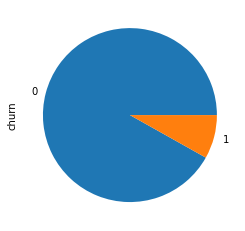

In [44]:
# looking for percentage of churn and non-churn data.
print((tc['churn'].value_counts()/len(tc))*100)
((tc['churn'].value_counts()/len(tc))*100).plot(kind="pie")
plt.show()

#### From the above pie chart it can be seen that the percentage of churn customers is only 8.1%.

In [45]:
# Now the churn column is derived so we have to drop all the columns having _9 in it as these are no longer useful. 
unwanted = [x for x in tc.columns if '_9' in x]
print(unwanted)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']


#### These are the ninth months columns and have to be emoved from the data set.

In [46]:
# Dropping the above columns.
tc.drop(unwanted, axis=1, inplace=True)
# Shape check.
tc.shape

(30001, 141)

#### Now, there are 141 columns and 30001 rows left with the data.  

In [47]:
# We have derived some columns in good phase for now we can remove those columns.
tc.drop(['total_rech_amt_data_6','av_rech_amt_data_6',
                   'total_rech_data_6','total_rech_amt_6',
                  'total_rech_amt_data_7','av_rech_amt_data_7',
                   'total_rech_data_7','total_rech_amt_7'], axis=1, inplace=True)

In [48]:
# check shape of data.
tc.shape

(30001, 133)

#### We have 133 columns left.

### Now check for multicollinearity present with the attributes of 6,7and 8 month.

In [49]:
# Creating individual column for month 6,7 and 8.
month6 = [y for y in tc.columns if '_6' in y]
month7 = [y for y in tc.columns if '_7' in y]
month8 = [y for y in tc.columns if '_8' in y]

In [50]:
# Check the correlation between the months columns.
# Drop highly correlated columns.
tc_corr = tc.corr()
tc_corr.loc[:,:] = np.tril(tc_corr, k=-1)
tc_corr = tc_corr.stack()
tc_corr
tc_corr[(tc_corr > 0.80) | (tc_corr < -0.80)].sort_values(ascending=False)

total_rech_amt_8    arpu_8                0.955351
isd_og_mou_8        isd_og_mou_7          0.943433
                    isd_og_mou_6          0.919641
isd_og_mou_7        isd_og_mou_6          0.916237
sachet_2g_8         total_rech_data_8     0.900629
total_ic_mou_6      loc_ic_mou_6          0.895099
total_ic_mou_8      loc_ic_mou_8          0.893072
total_ic_mou_7      loc_ic_mou_7          0.883070
std_og_t2t_mou_8    onnet_mou_8           0.860483
std_og_t2t_mou_7    onnet_mou_7           0.860275
std_og_t2t_mou_6    onnet_mou_6           0.859593
avg_rech_amt_6_7    overall_rech_amt_7    0.856275
std_og_t2m_mou_7    offnet_mou_7          0.854685
std_og_t2m_mou_8    offnet_mou_8          0.851049
total_og_mou_8      std_og_mou_8          0.848858
total_og_mou_7      std_og_mou_7          0.848825
loc_ic_mou_8        loc_ic_t2m_mou_8      0.847512
std_ic_mou_8        std_ic_t2m_mou_8      0.845590
loc_ic_mou_6        loc_ic_t2m_mou_6      0.844418
loc_og_mou_8        loc_og_mou_

#### As there are so many colums are highly correlated.
#### Drop those columns whos correlation is greater than 85%.

In [51]:
# Making group of columns having greater than 85% correlation.
corr85=['total_rech_amt_8','isd_og_mou_8','isd_og_mou_7','sachet_2g_8','total_ic_mou_6',
            'total_ic_mou_8','total_ic_mou_7','std_og_t2t_mou_6','std_og_t2t_mou_8','std_og_t2t_mou_7',
            'std_og_t2m_mou_7','std_og_t2m_mou_8',]
# Droping the above columns.
tc.drop(corr85, axis=1, inplace=True)

In [52]:
# Check for shape of the data.
tc.shape

(30001, 121)

#### Now, 121 rows have been left in the data.

#### Deriving new variable tenure from aon column.

In [53]:
# Creating new variable tenure.
tc['tenure'] = (tc['aon']/30).round(0)

# Drop aon column.
tc.drop('aon',axis=1, inplace=True)

<AxesSubplot:xlabel='tenure', ylabel='Density'>

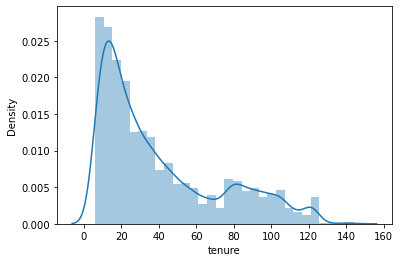

In [54]:
# Check for the distribution of tenure column.

sns.distplot(tc['tenure'],bins=30)

In [55]:
tnr = [0, 6, 12, 24, 60, 61]
tnl = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tc['tenure_range'] = pd.cut(tc['tenure'], tnr, labels=tnl)
tc['tenure_range'].head()

0     2-5 Yrs    
7     2-5 Yrs    
8     6-12 Months
21    1-2 Yrs    
23    1-2 Yrs    
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

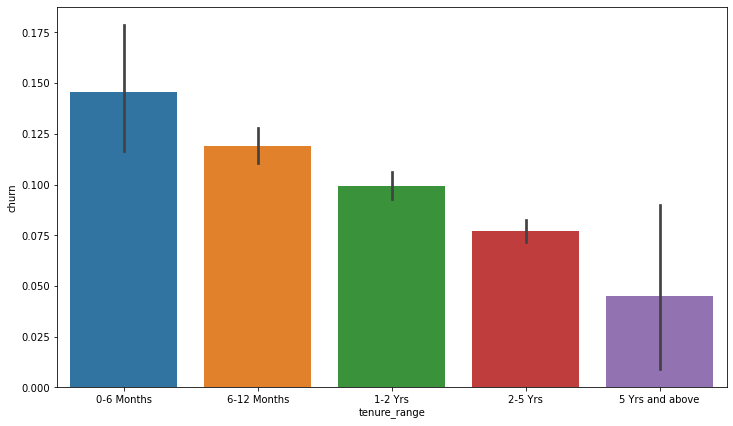

In [56]:
# Plotting bar blop between tenure range and target variable.
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn', data=tc)
plt.show()

#### It is clear from the bar plot that tenure is important variable for defining churn.
#### As tenure increases probability of churn decreases.

In [57]:
# The average revenue per user in good phase is defined by arpu_6 and arpu_7 columns. Lets take avg for both and drop both columns.

# Taking average of arpu_6 and arpu_7 columns.
tc["avg_arpu_6_7"]= (tc['arpu_6']+tc['arpu_7'])/2
tc['avg_arpu_6_7'].head()



0     206.1005 
7     1209.5150
8     435.4720 
21    556.1030 
23    134.1235 
Name: avg_arpu_6_7, dtype: float64

In [58]:

# Drop arpu_6 and arpu_7 columns.
tc.drop(['arpu_6','arpu_7'], axis=1, inplace=True)

# Check shape of the data.
tc.shape

(30001, 121)

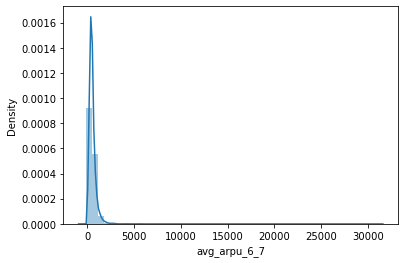

In [59]:
# Visualising avg_arpu_6_7 column.
# Visualizing the column created
sns.distplot(tc['avg_arpu_6_7'])
plt.show()

Text(0.5, 1.0, 'correlation with Churn variable')

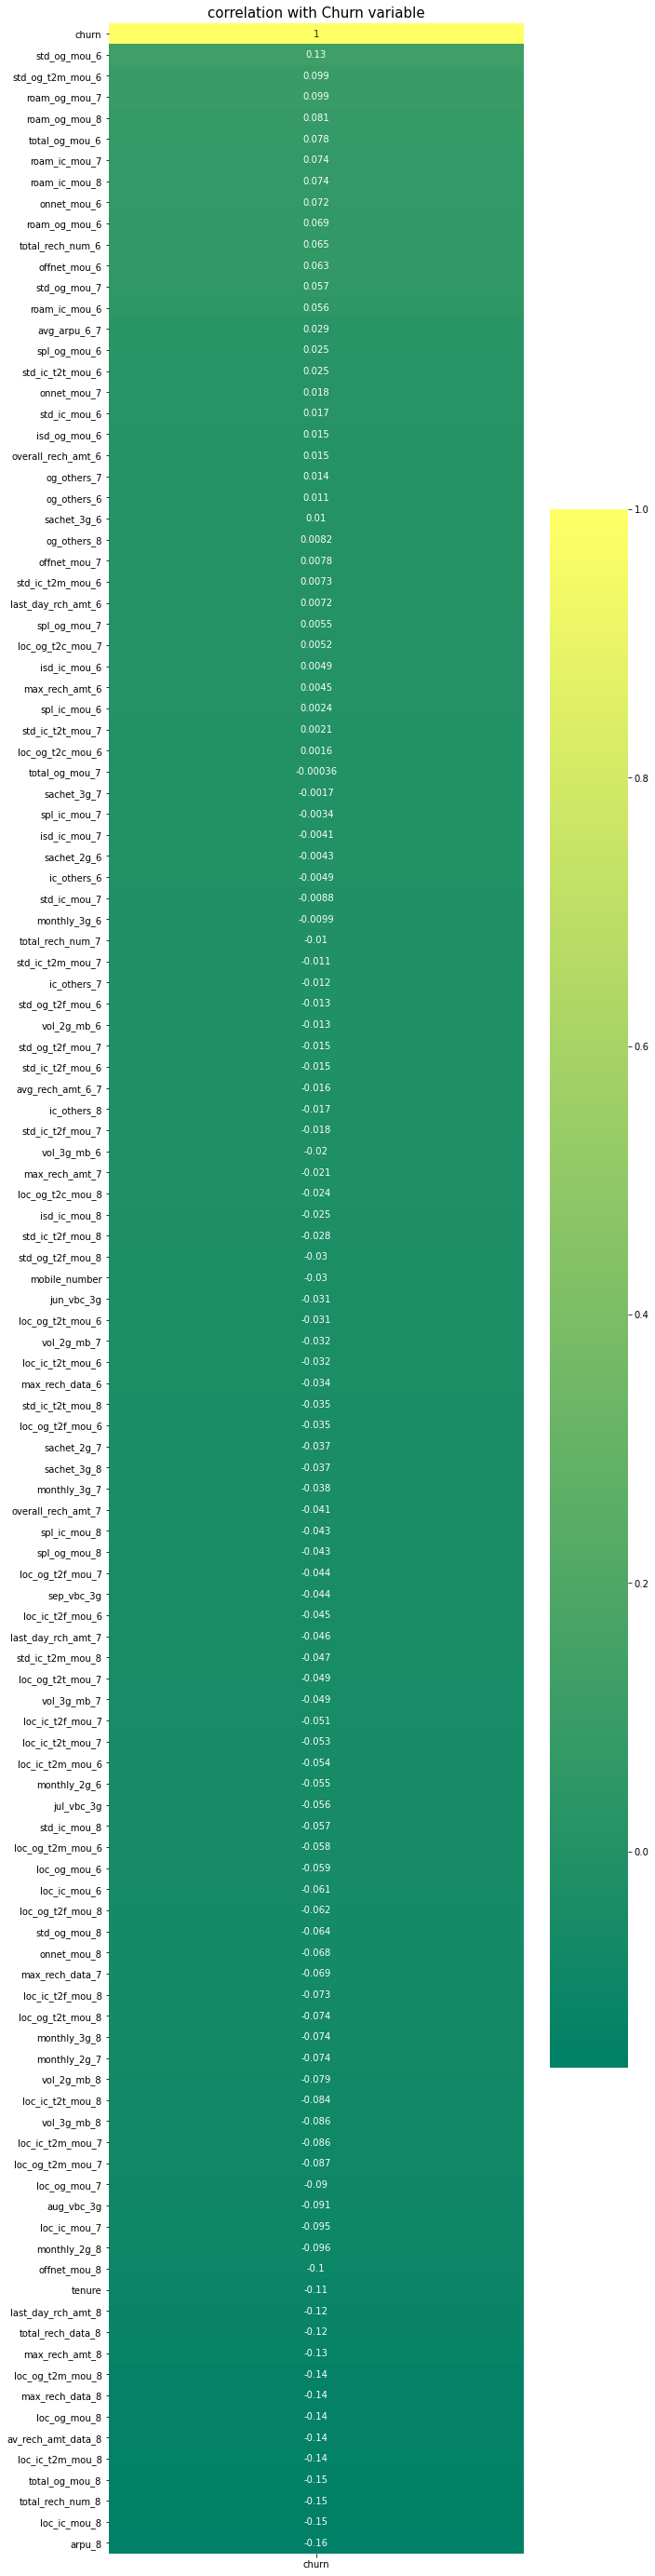

In [60]:
# checking the correlation between target variables and other variables.
plt.figure(figsize=(10,50))
correlation = sns.heatmap(tc.corr()[['churn']].sort_values(ascending=False, by='churn'),annot=True, 
                                cmap='summer')
correlation.set_title("correlation with Churn variable", fontsize=15)

#### Average outgoing calls and calls for roaming are positively correlated.
#### Average revenue and no of recharges are negatively correlated.

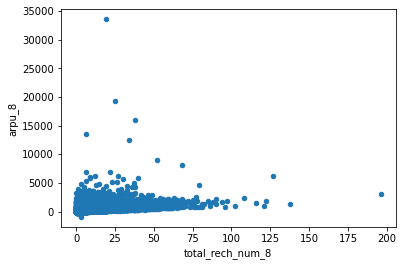

In [61]:
# Make scatter plot between total recharge and average revenue for the 8th month.
tc[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')
plt.show()

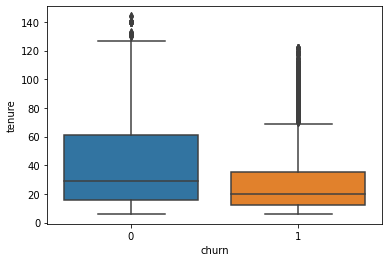

In [62]:
# Make box plot for more clear picture about the data.
sns.boxplot(x = tc.churn, y = tc.tenure)

plt.show()

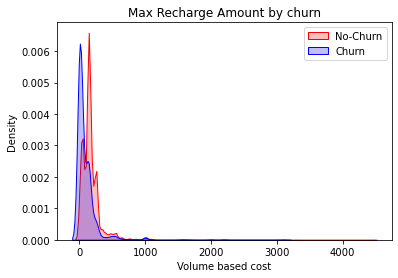

In [63]:
# Plot between churn vs max rechare amount
ax = sns.kdeplot(tc.max_rech_amt_8[(tc["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(tc.max_rech_amt_8[(tc["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Max Recharge Amount by churn')
plt.show()

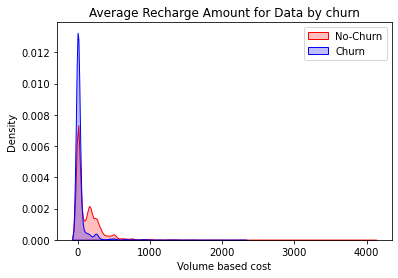

In [64]:
#  plot betweenchurn and average rechare amount
ax = sns.kdeplot(tc.av_rech_amt_data_8[(tc["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(tc.av_rech_amt_data_8[(tc["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Average Recharge Amount for Data by churn')
plt.show()

In [65]:
# Creating categories for month 8 column totalrecharge and their count
tc['total_rech_data_group_8']=pd.cut(tc['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
tc['total_rech_num_group_8']=pd.cut(tc['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

					Distribution of total_rech_data_8 variable
 <=10_Recharges     15307
No_Recharge        14048
10-25_Recharges    608  
>25_Recharges      38   
Name: total_rech_data_group_8, dtype: int64


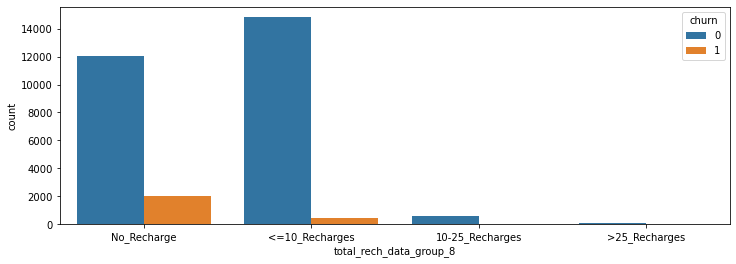

					Distribution of total_rech_num_8 variable
 <=10_Recharges     19349
10-25_Recharges    8073 
>25_Recharges      1996 
No_Recharge        583  
Name: total_rech_num_group_8, dtype: int64


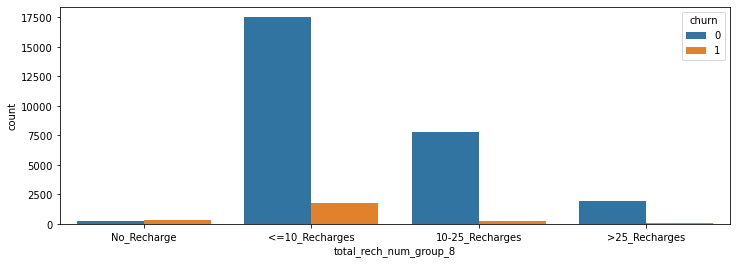

In [66]:
# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=tc,x="total_rech_data_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_data_8 variable\n",tc['total_rech_data_group_8'].value_counts())
plt.show()
plt.figure(figsize=[12,4])
sns.countplot(data=tc,x="total_rech_num_group_8",hue="churn")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",tc['total_rech_num_group_8'].value_counts())
plt.show()

#### It can be seen that churn rate decreases as the no of recharges increases.

In [67]:
tc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 123 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   mobile_number            float64 
 1   arpu_8                   float64 
 2   onnet_mou_6              float64 
 3   onnet_mou_7              float64 
 4   onnet_mou_8              float64 
 5   offnet_mou_6             float64 
 6   offnet_mou_7             float64 
 7   offnet_mou_8             float64 
 8   roam_ic_mou_6            float64 
 9   roam_ic_mou_7            float64 
 10  roam_ic_mou_8            float64 
 11  roam_og_mou_6            float64 
 12  roam_og_mou_7            float64 
 13  roam_og_mou_8            float64 
 14  loc_og_t2t_mou_6         float64 
 15  loc_og_t2t_mou_7         float64 
 16  loc_og_t2t_mou_8         float64 
 17  loc_og_t2m_mou_6         float64 
 18  loc_og_t2m_mou_7         float64 
 19  loc_og_t2m_mou_8         float64 
 20  loc_og_t2f_mou_6         fl

### OUTLIER TREATMENT

In [68]:
# Grouping numerical variables.
cat_vars=['tenure_range','total_rech_data_group_8','total_rech_num_group_8','churn']
num_vars=[]
for i in tc.columns:
    if i in cat_vars:
        pass
    else:
        num_vars.append(i)

In [69]:
# making perecentuiles.
tc[num_vars].describe(percentiles=[0,0.05,0.15,0.25,0.75,0.95,0.99,1])[1:].style.background_gradient(cmap='Reds')

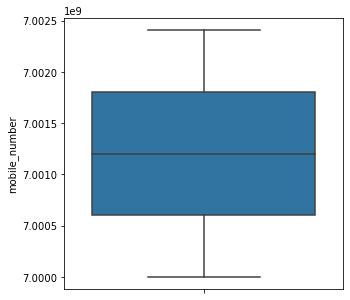

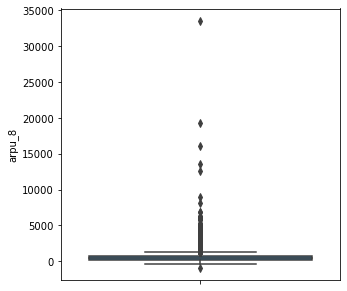

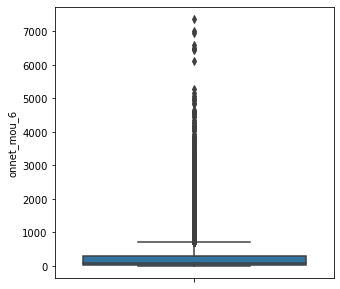

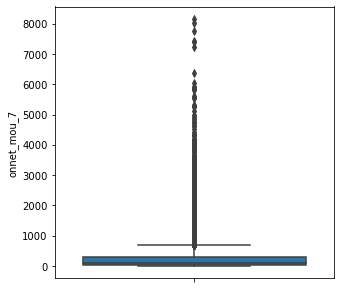

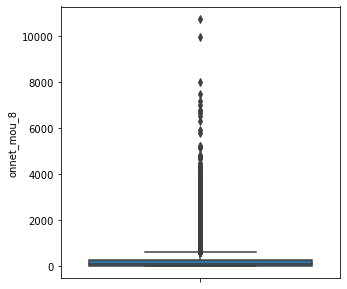

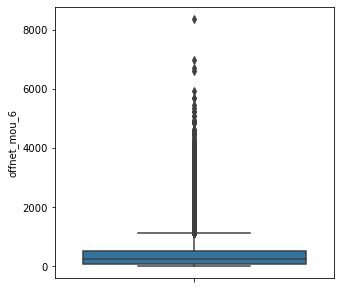

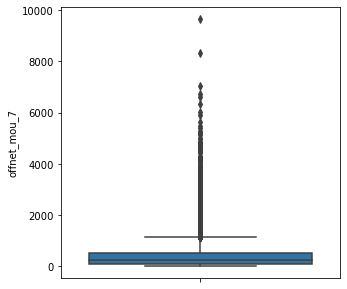

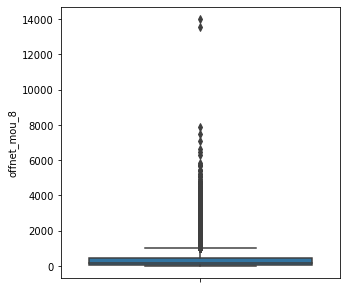

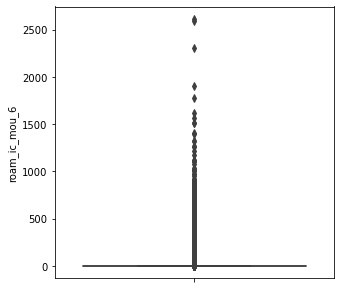

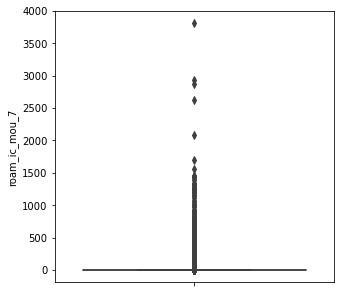

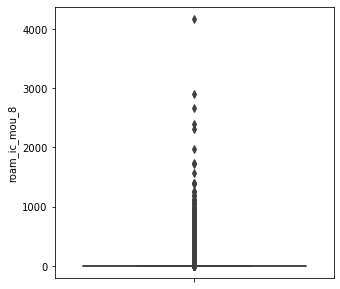

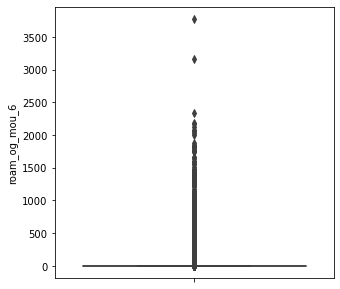

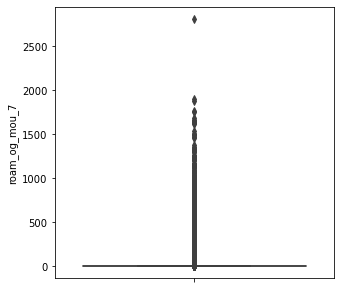

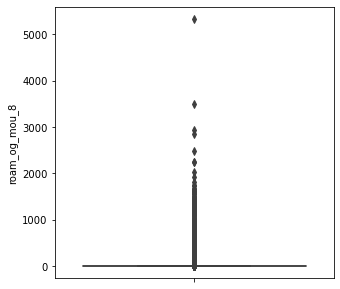

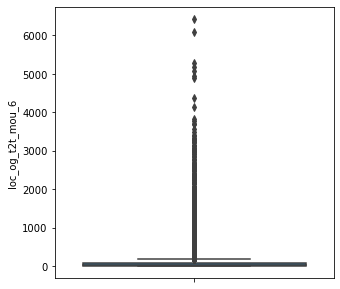

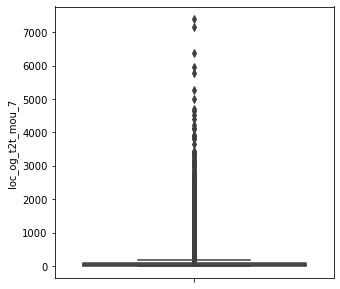

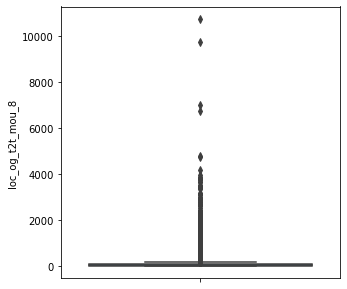

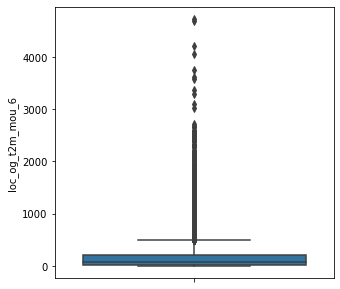

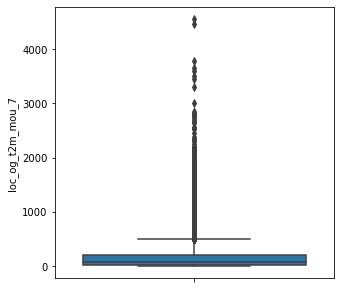

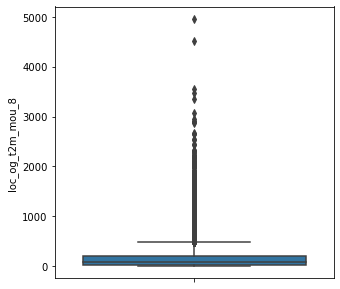

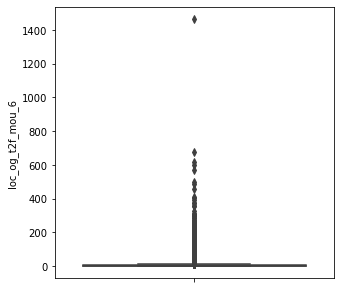

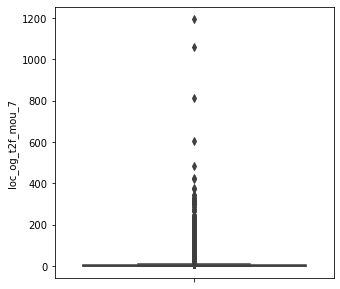

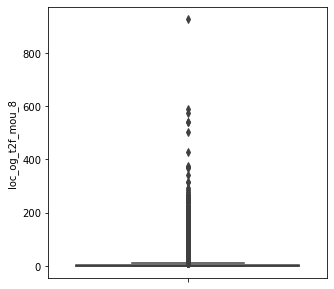

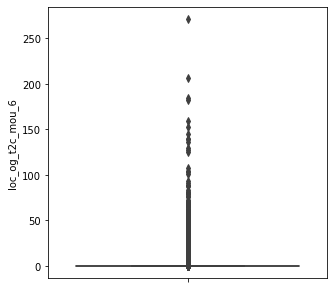

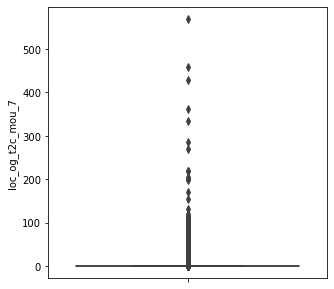

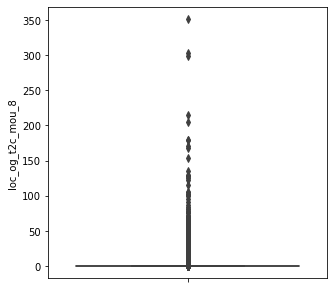

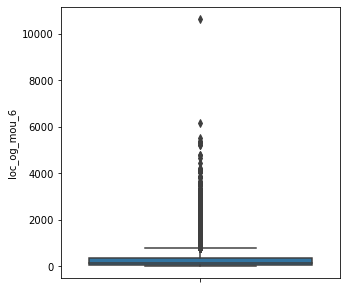

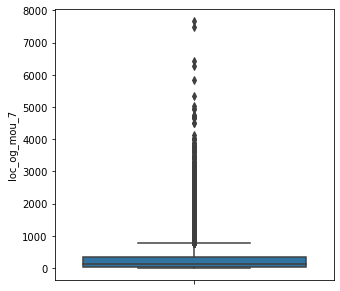

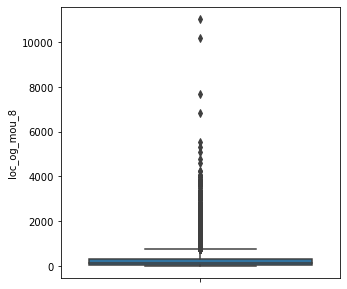

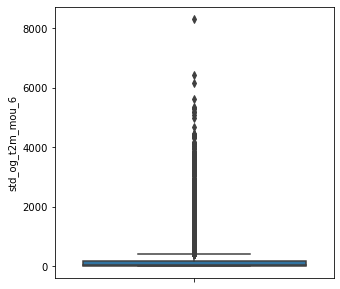

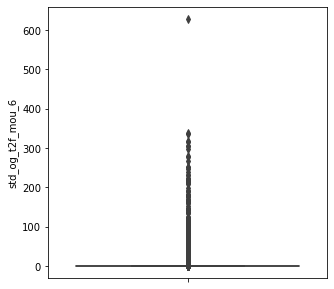

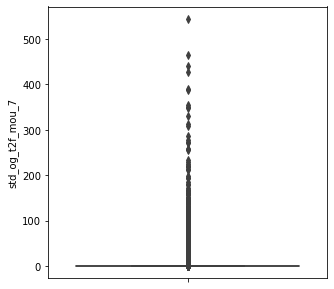

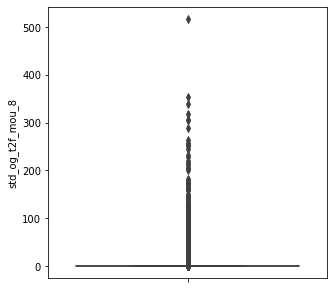

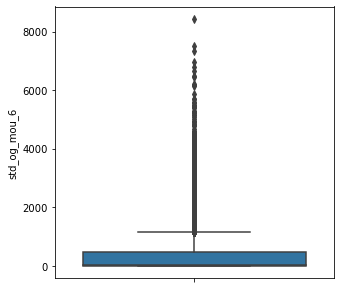

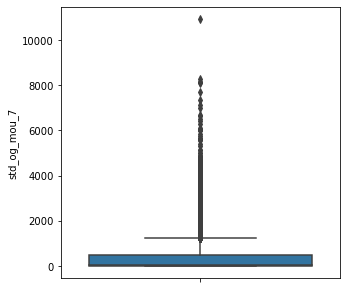

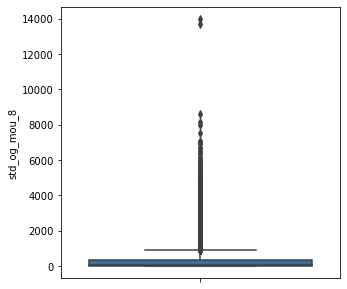

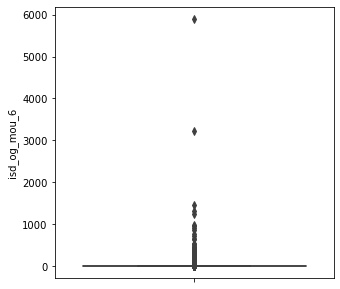

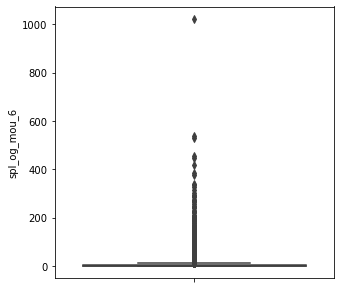

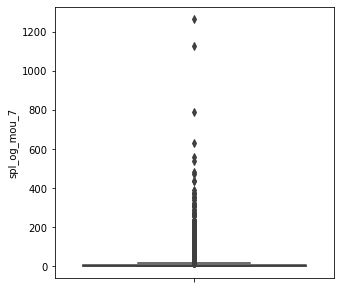

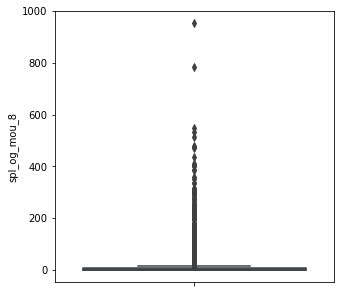

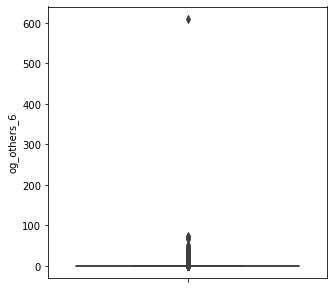

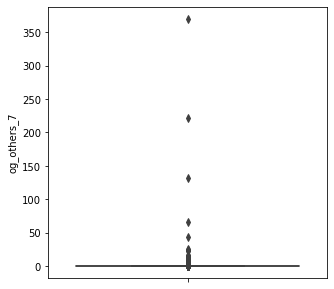

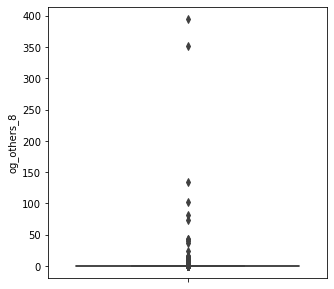

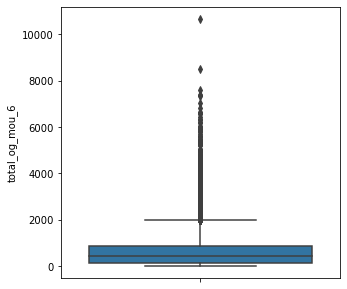

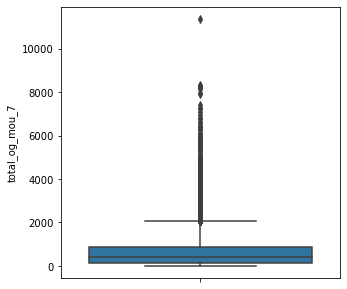

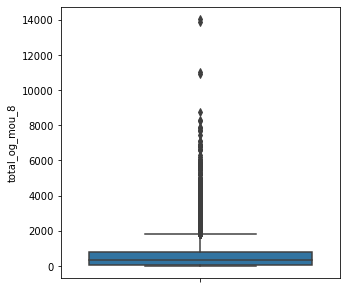

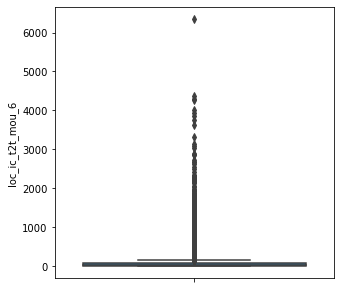

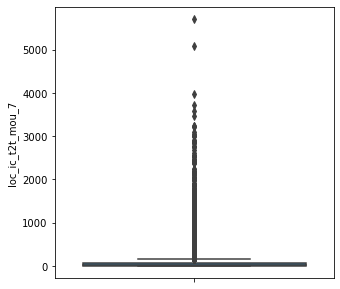

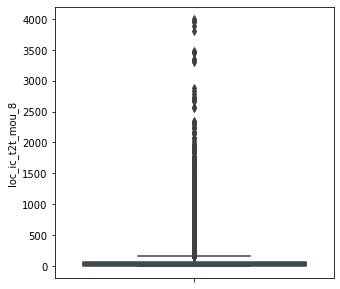

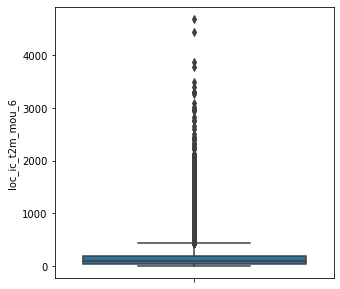

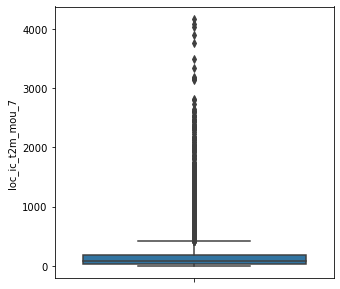

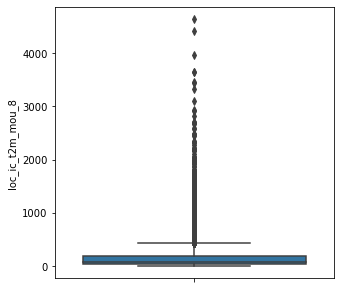

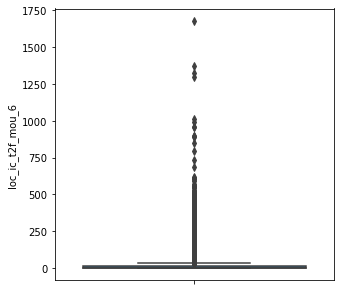

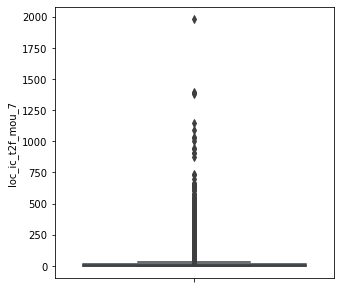

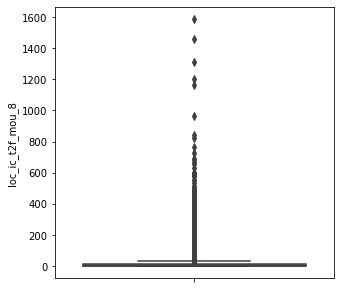

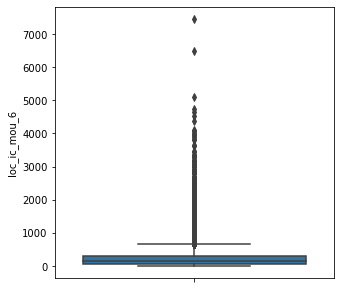

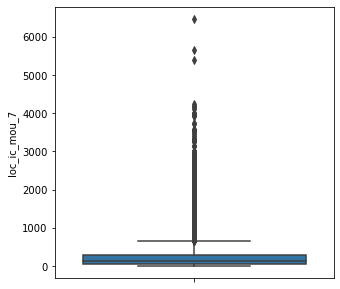

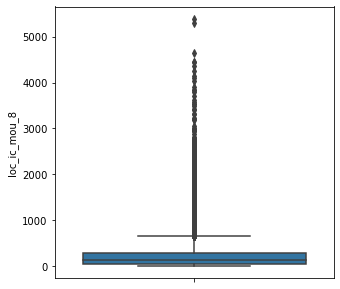

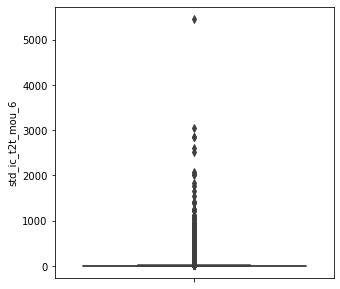

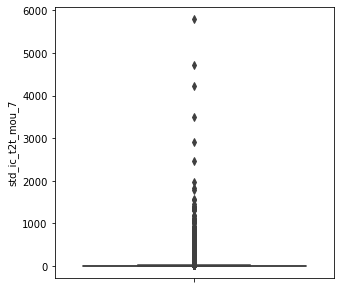

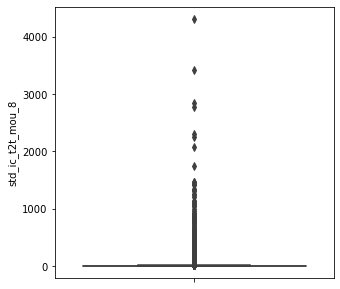

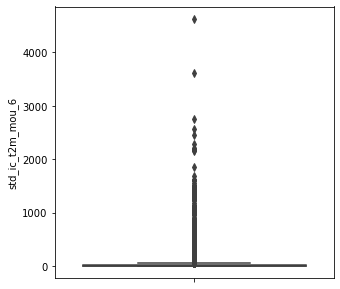

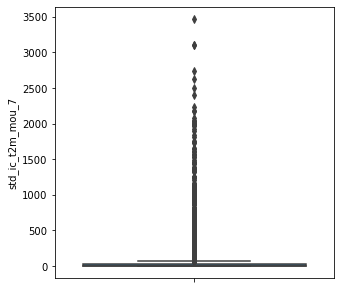

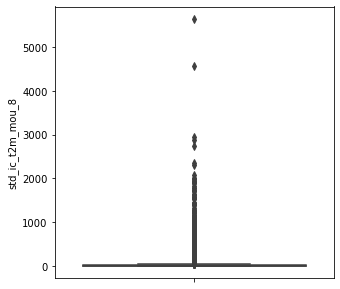

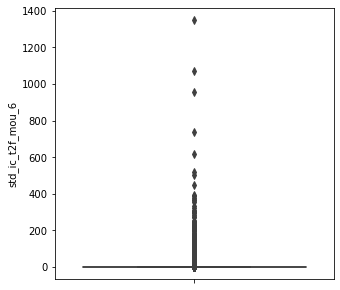

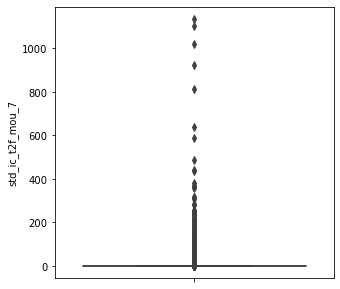

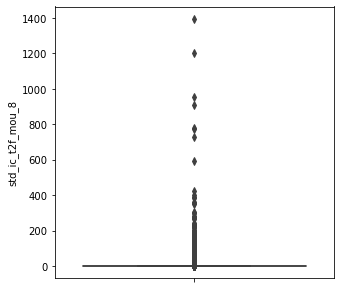

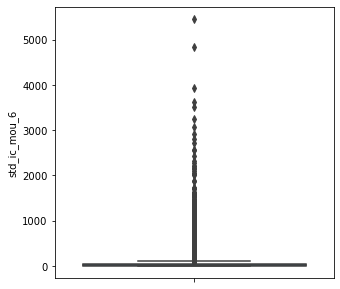

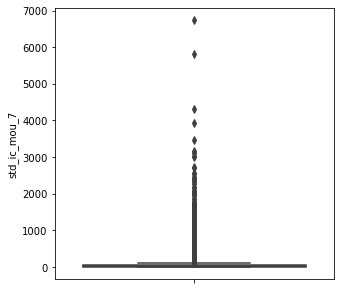

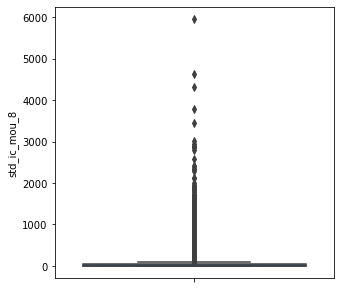

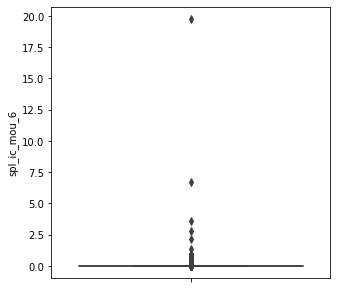

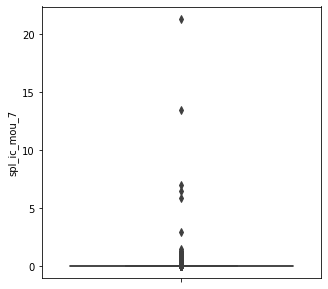

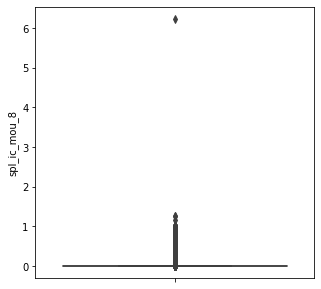

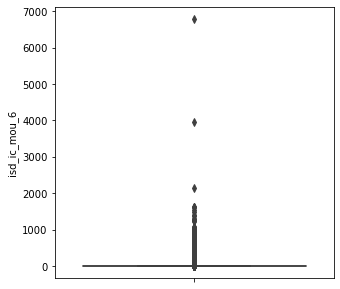

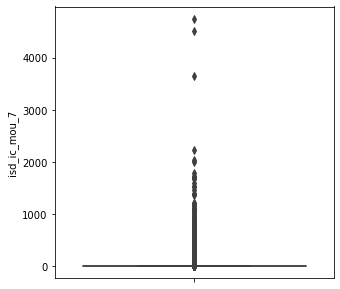

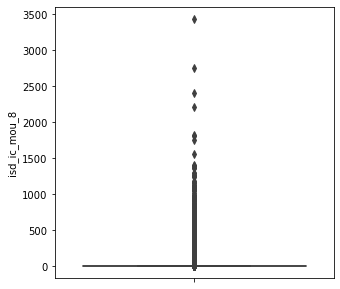

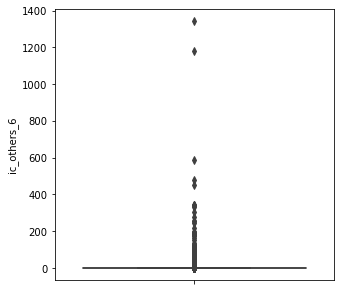

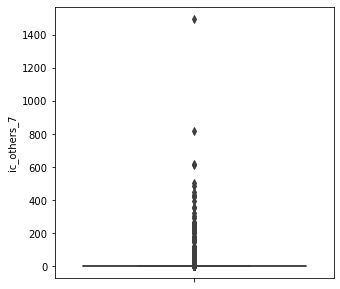

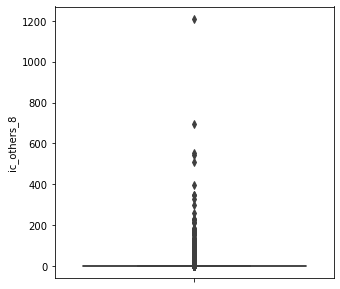

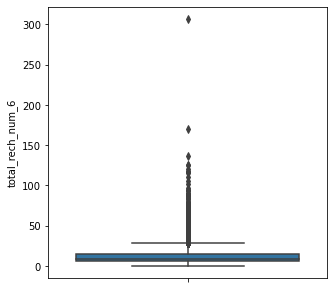

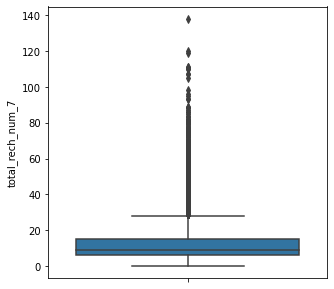

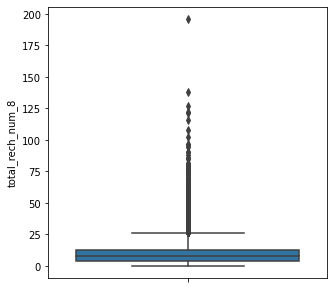

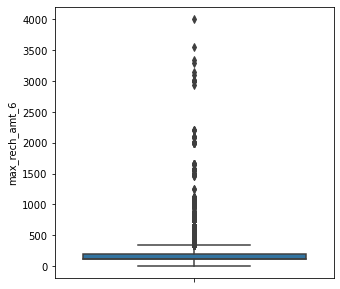

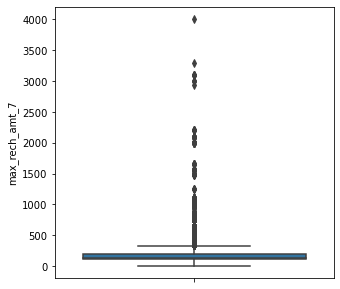

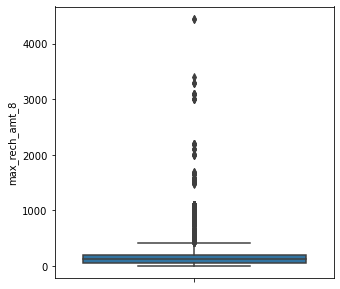

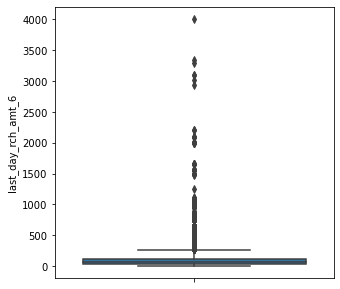

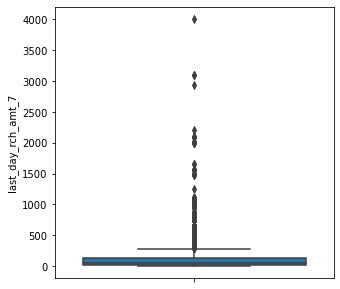

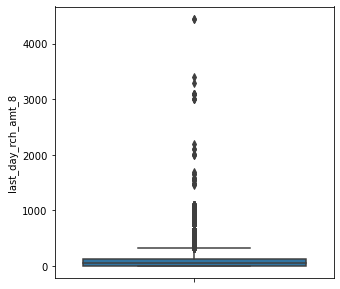

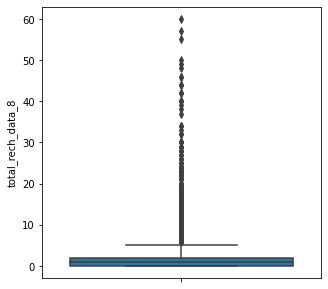

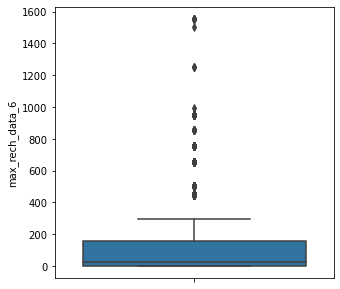

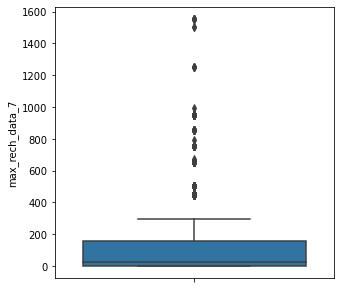

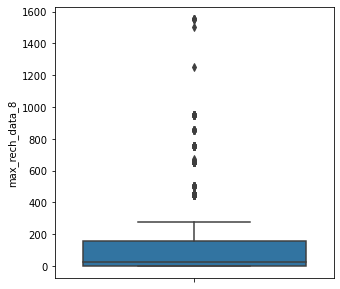

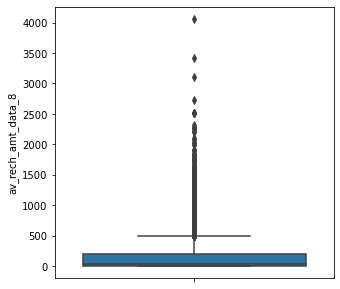

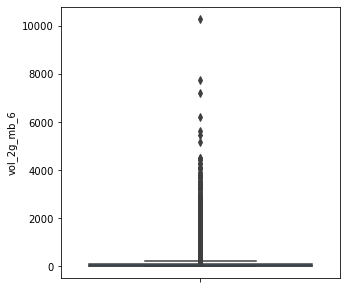

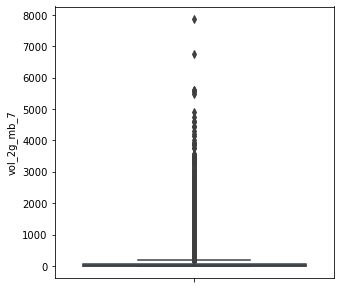

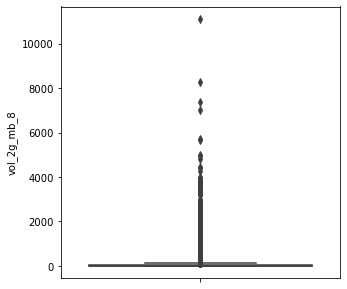

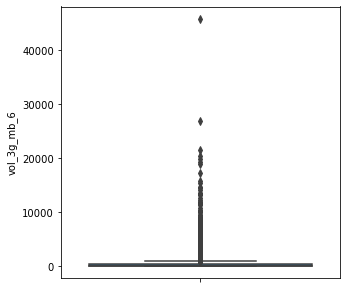

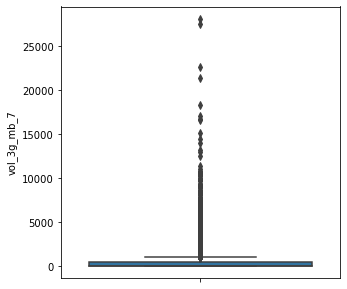

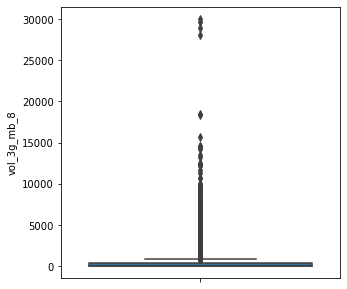

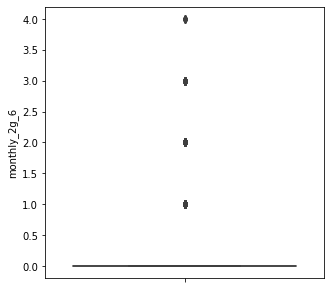

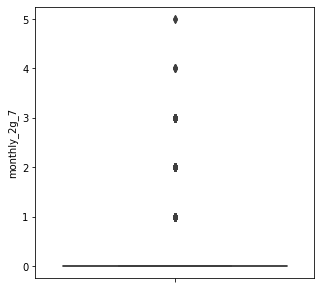

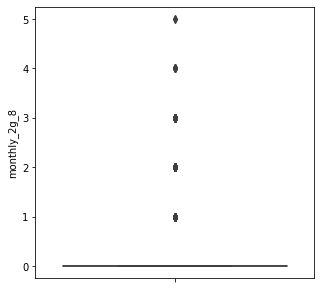

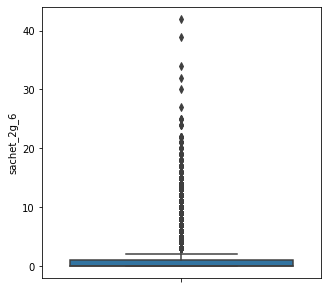

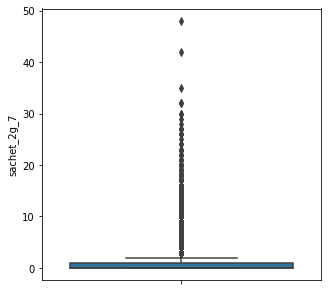

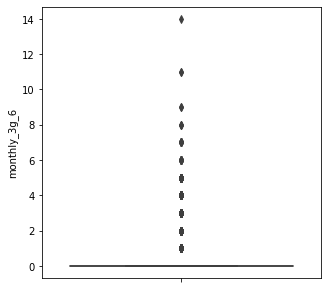

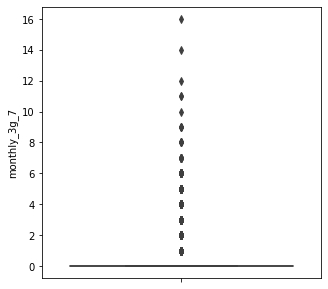

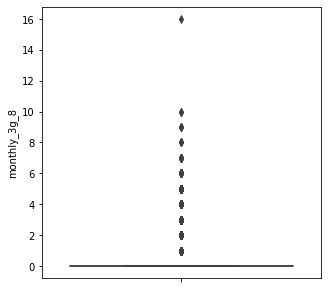

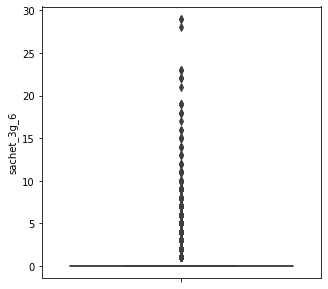

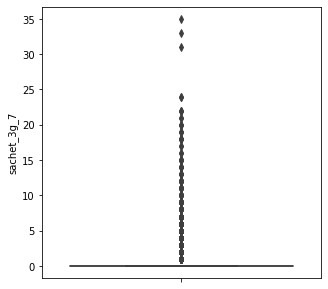

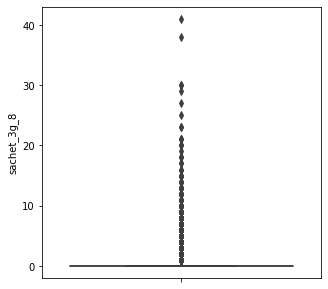

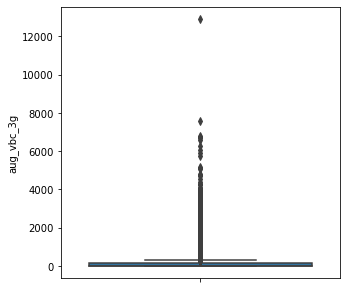

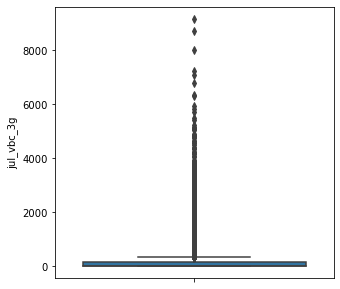

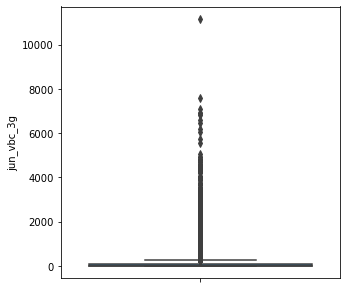

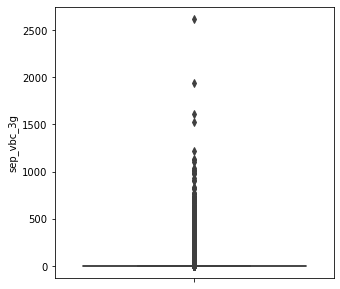

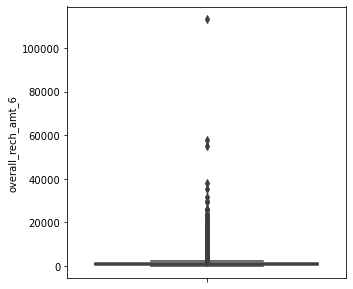

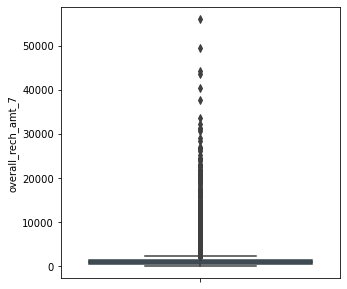

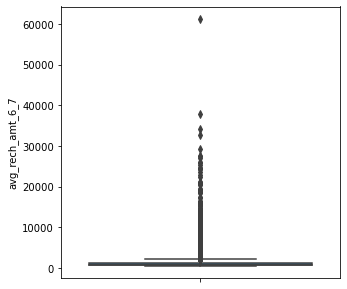

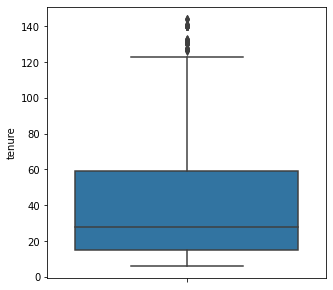

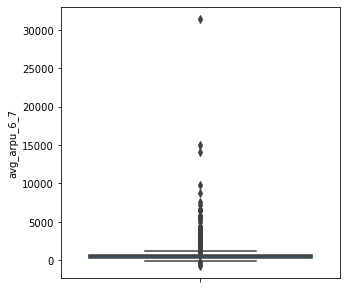

In [70]:
# Looking for box plot for visualising the outliers.
for col in num_vars:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=tc)

#### There are oullier present in the data so, we have to handle the same.

### Using k-sigma method for capping outlier.

In [71]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [72]:
# example of capping
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [73]:
# Outlier capping.
tc[num_vars] = tc[num_vars].apply(cap_outliers, axis=0)

In [74]:
tc[num_vars].describe(percentiles=[0,0.05,0.15,0.25,0.75,0.95,0.99,1])[1:].style.background_gradient(cmap='Reds')

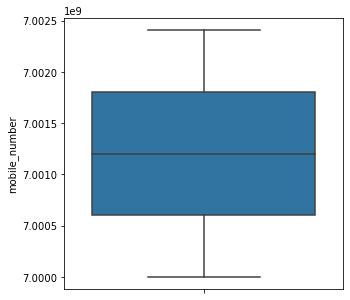

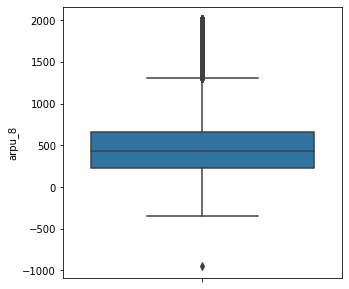

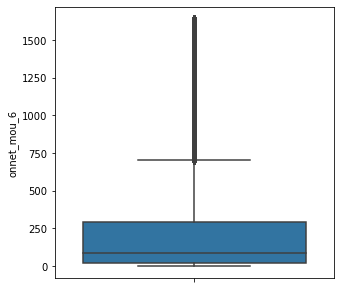

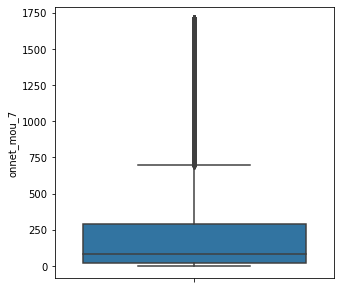

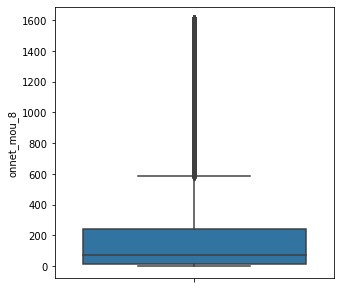

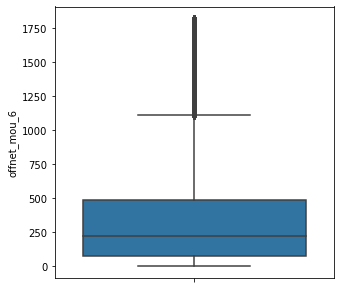

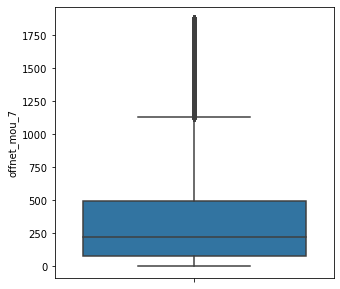

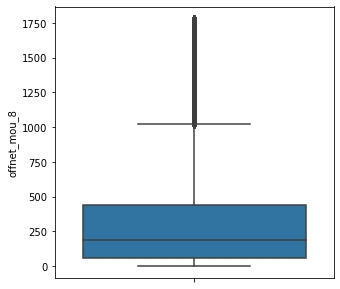

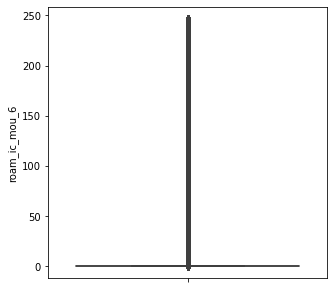

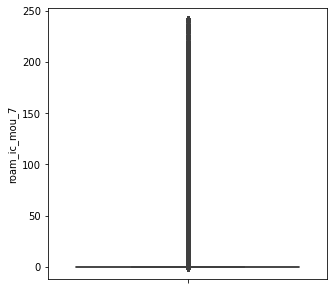

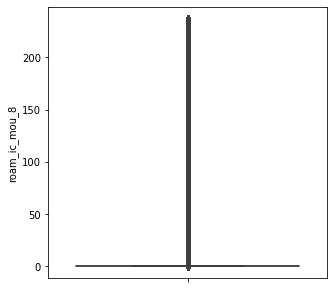

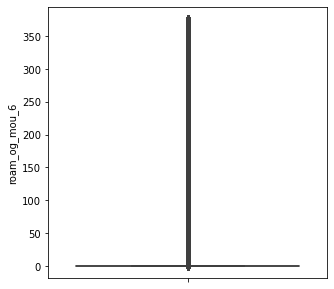

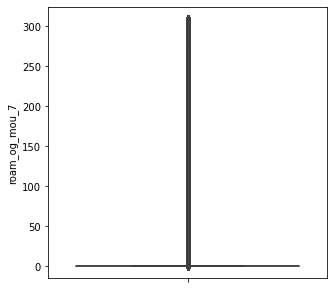

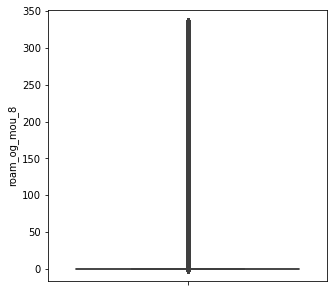

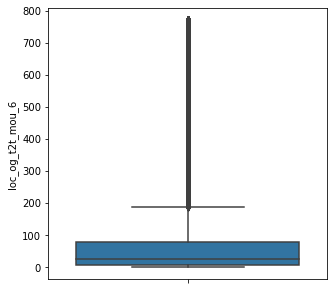

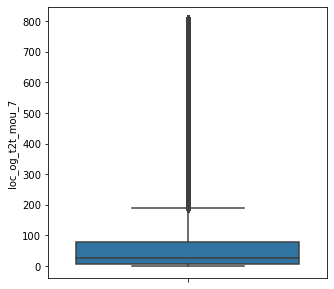

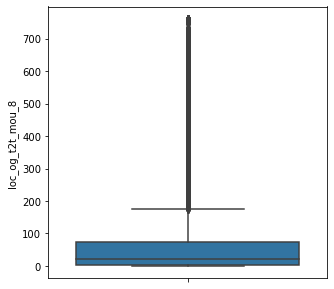

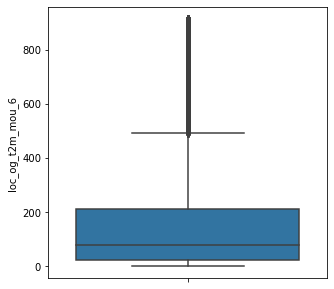

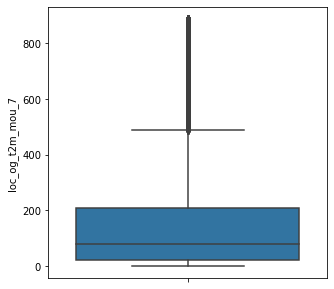

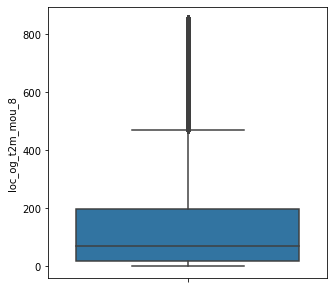

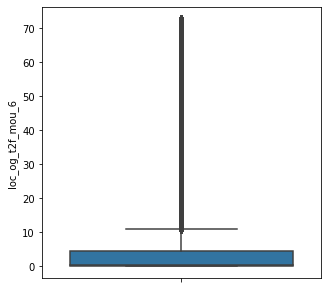

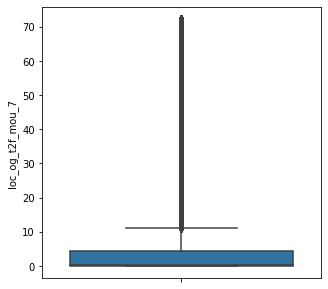

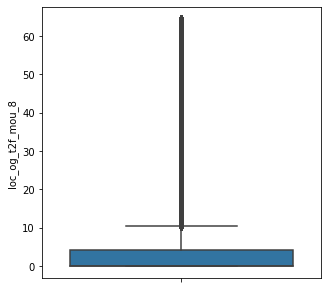

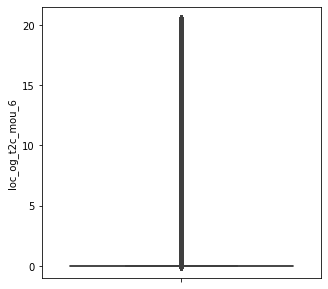

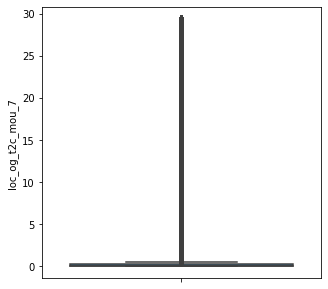

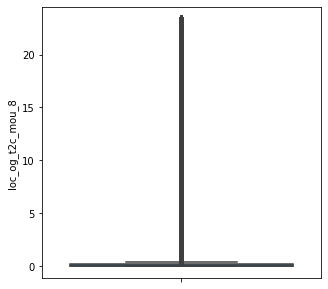

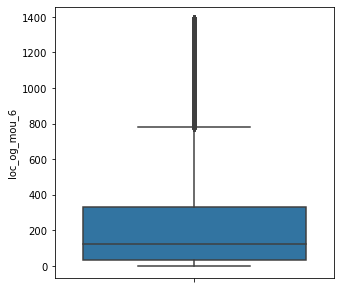

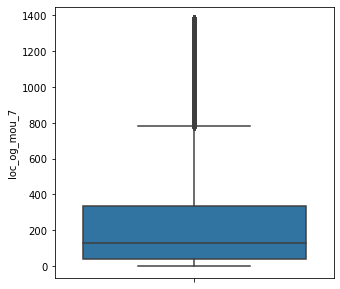

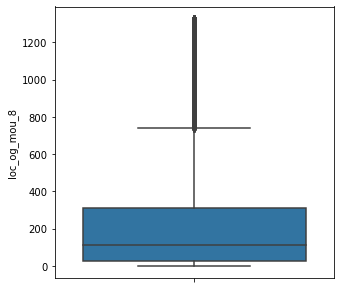

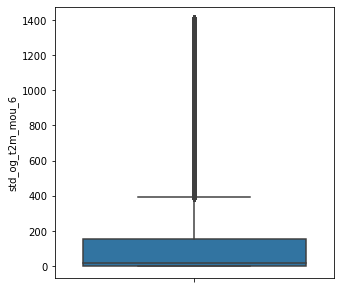

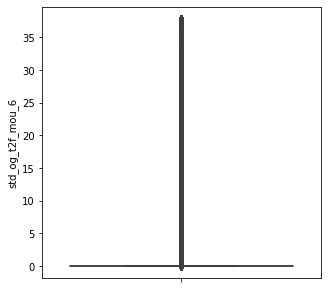

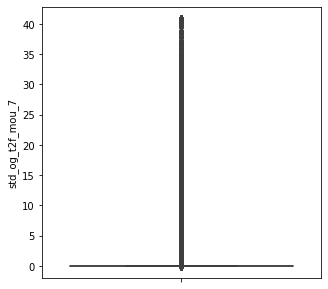

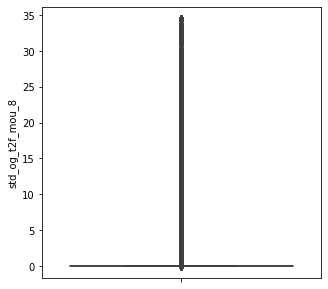

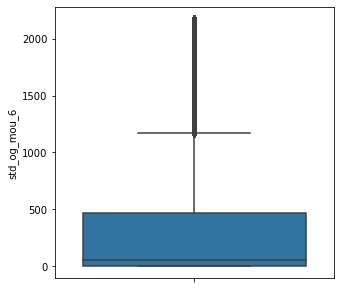

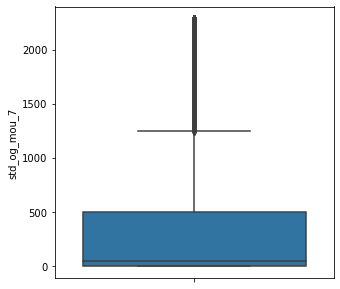

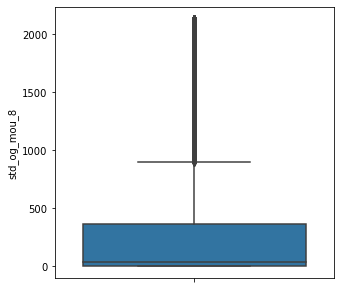

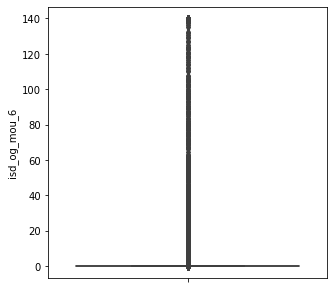

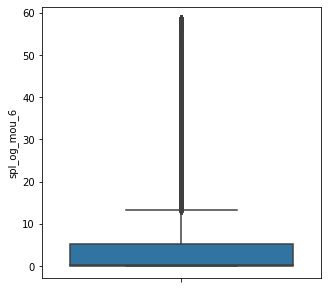

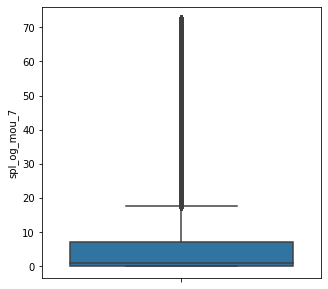

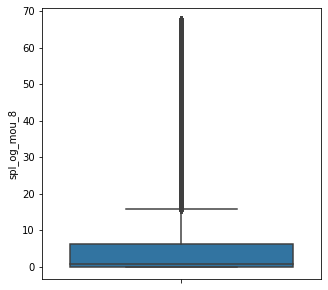

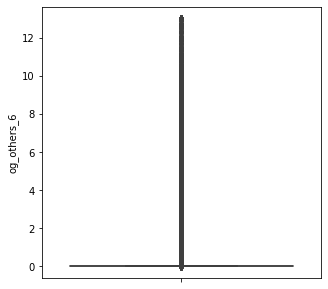

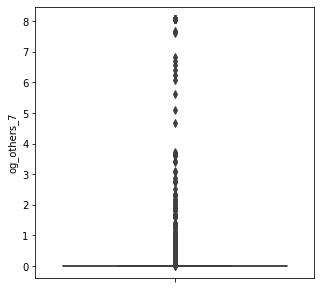

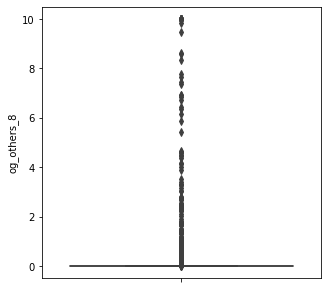

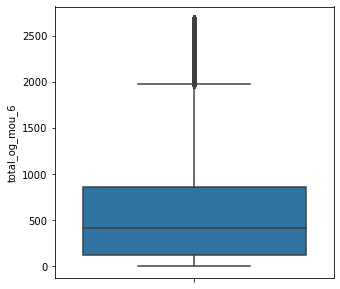

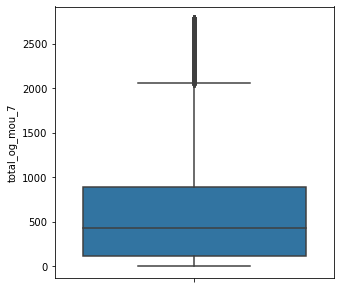

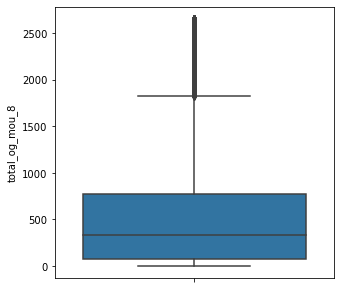

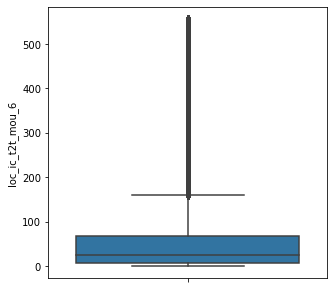

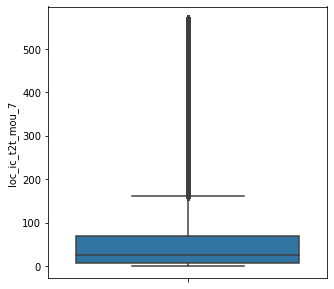

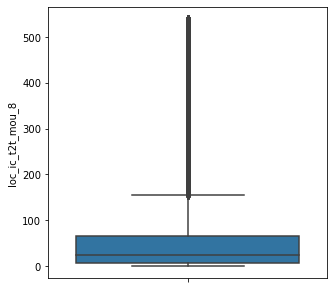

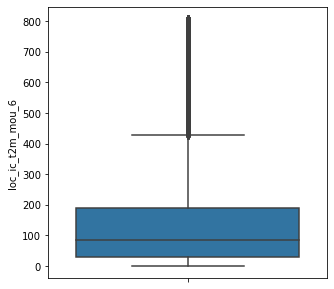

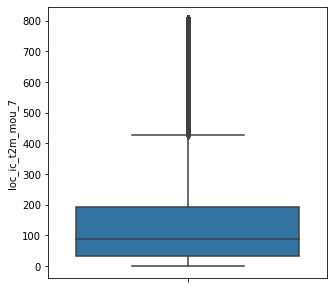

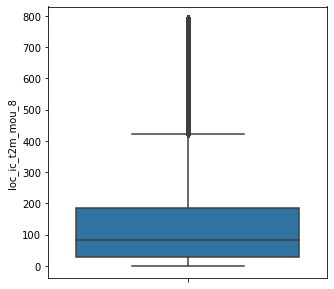

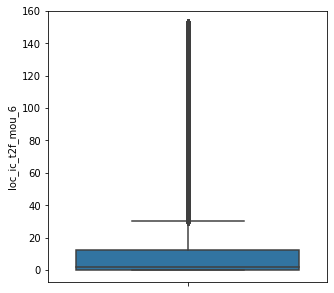

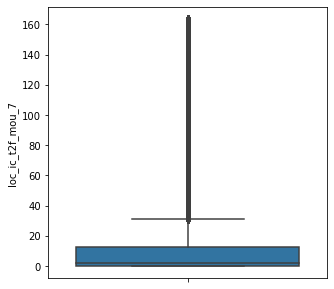

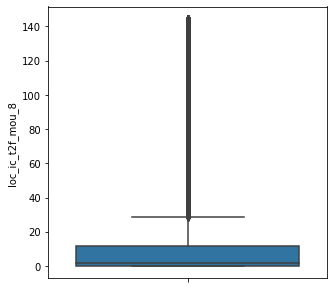

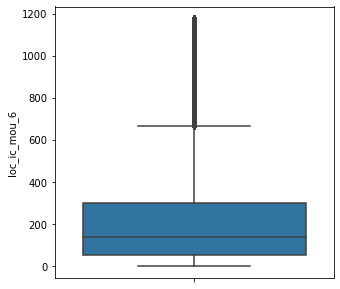

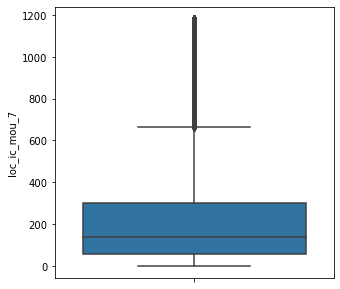

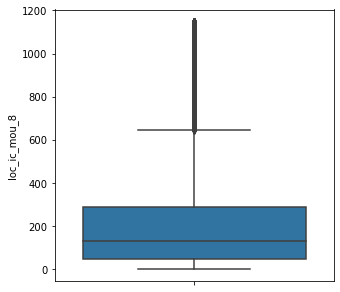

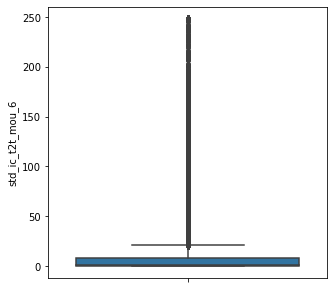

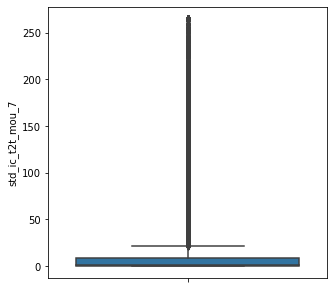

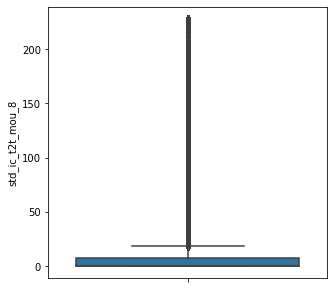

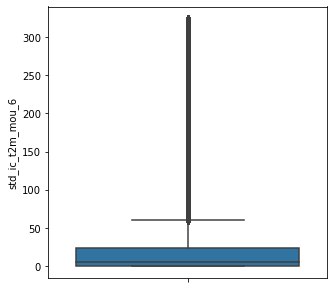

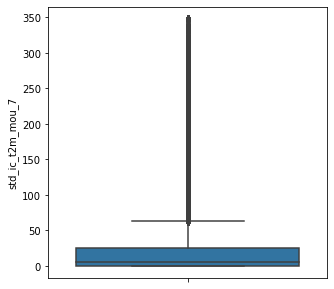

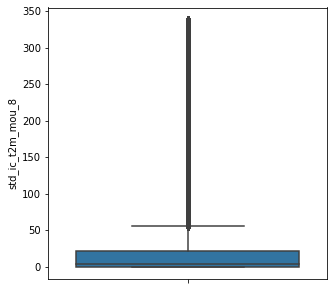

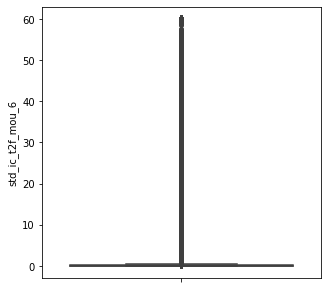

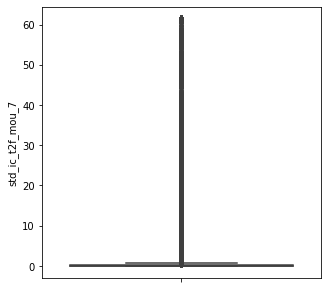

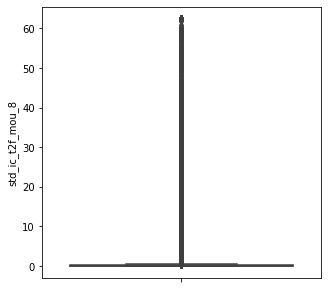

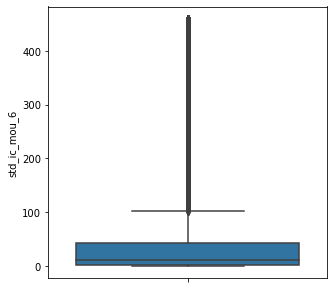

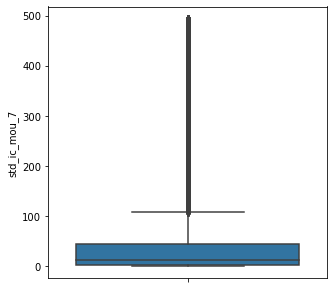

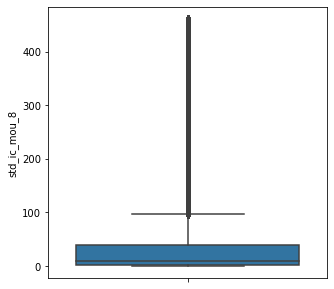

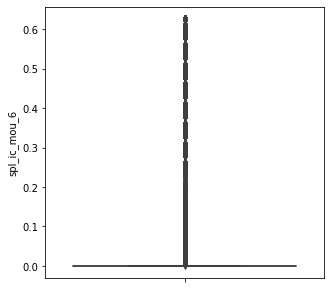

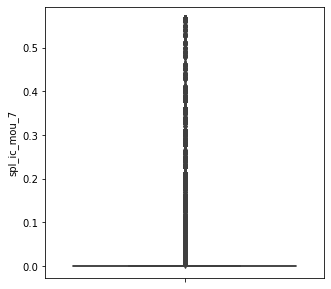

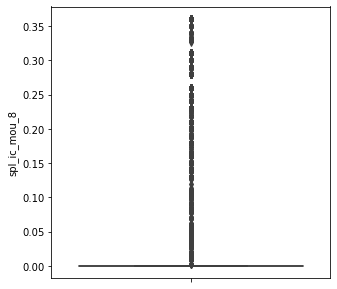

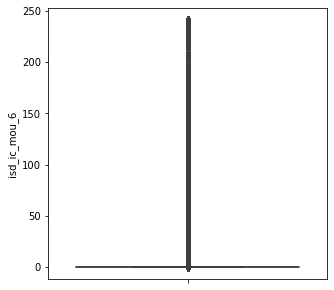

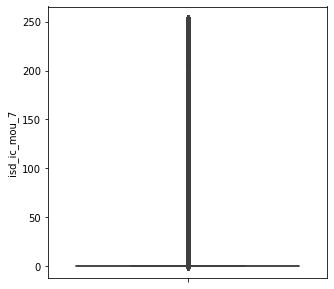

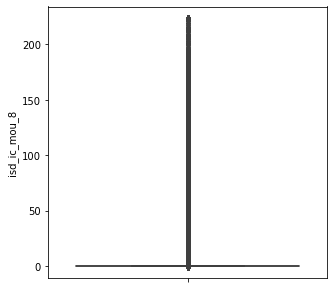

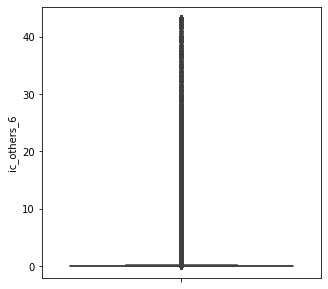

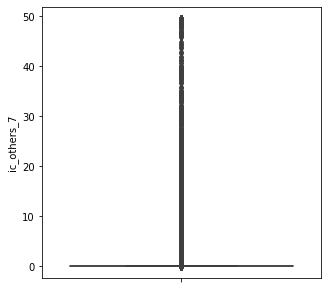

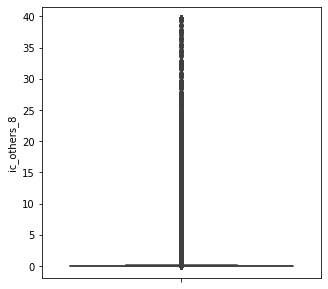

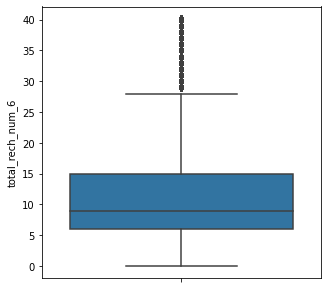

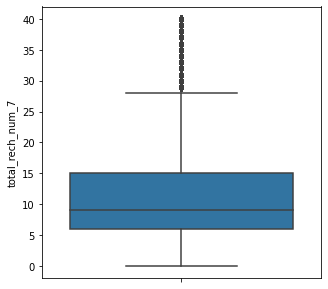

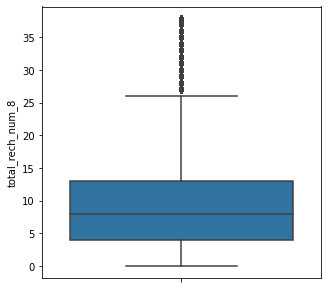

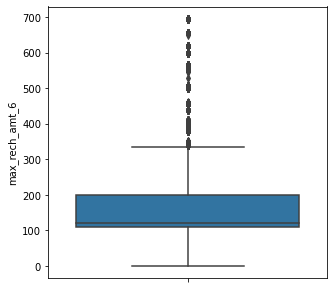

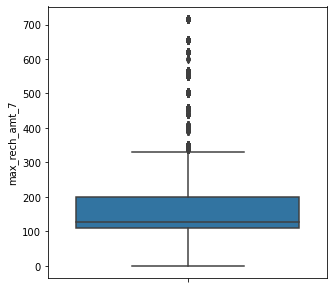

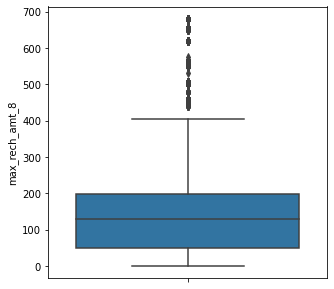

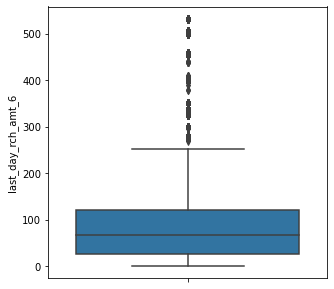

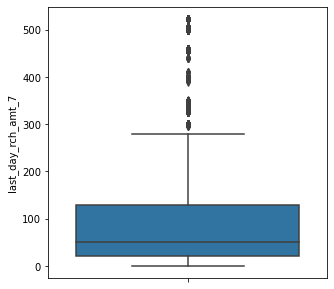

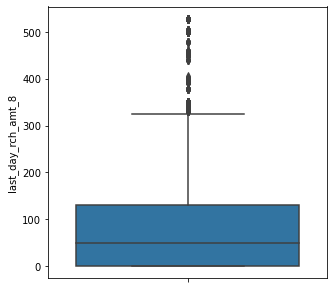

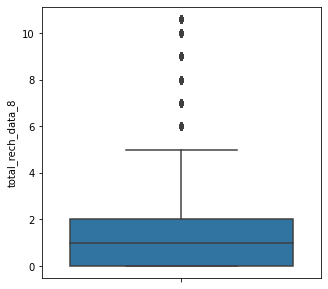

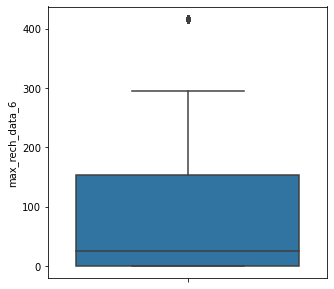

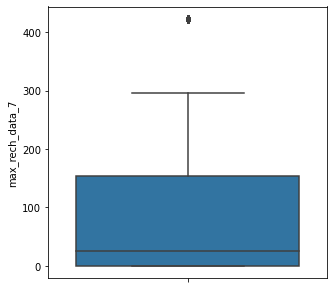

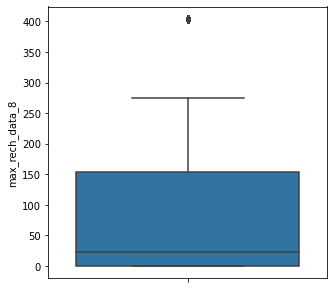

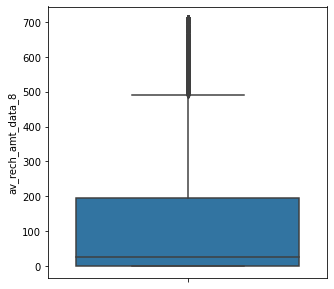

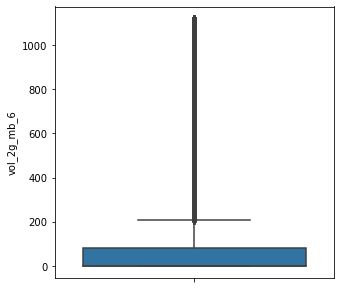

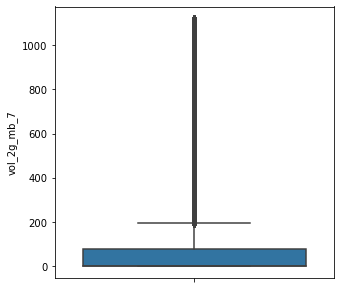

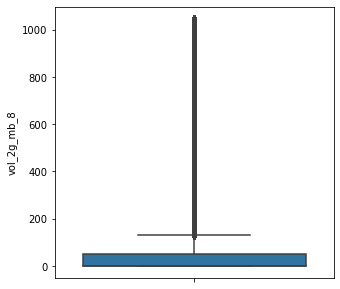

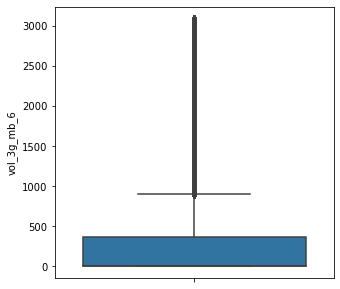

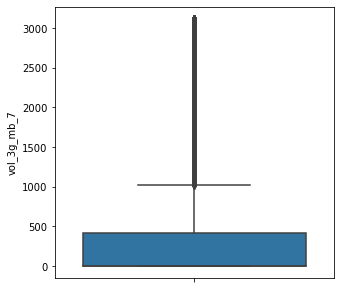

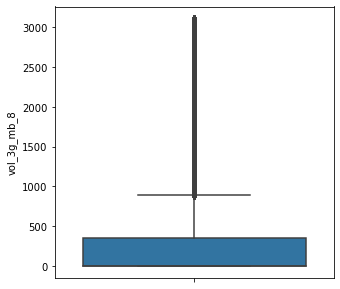

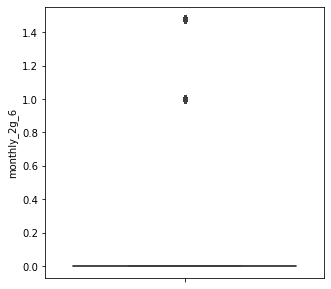

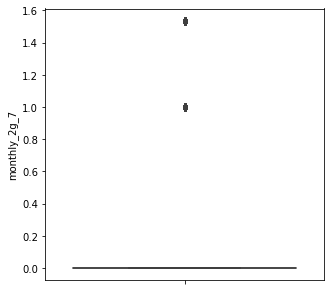

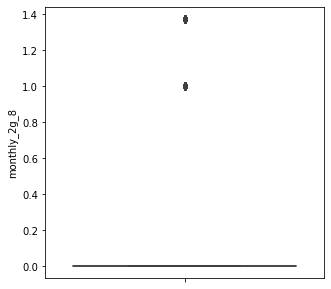

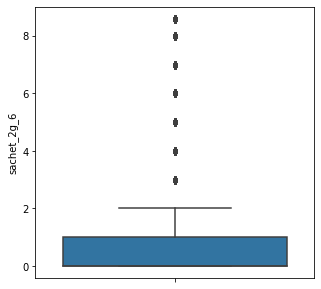

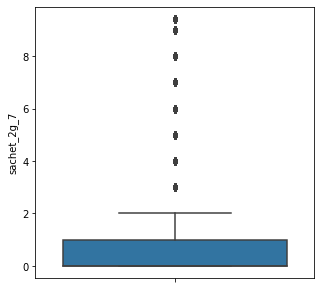

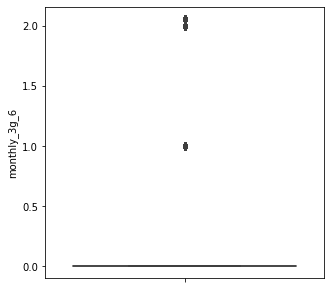

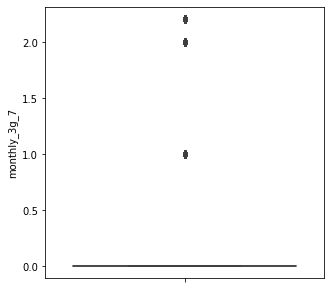

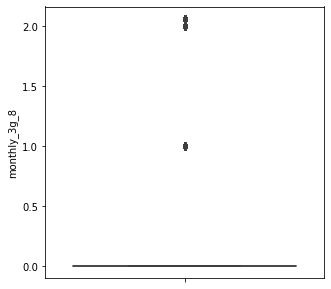

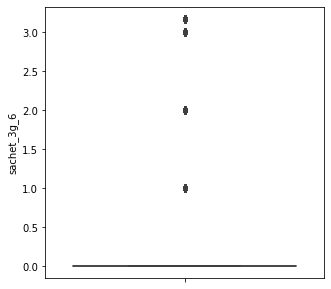

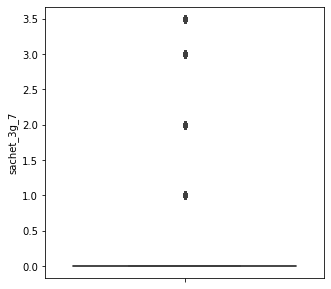

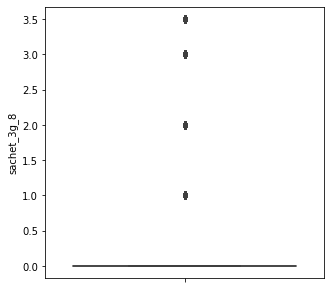

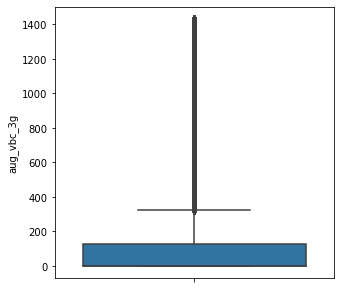

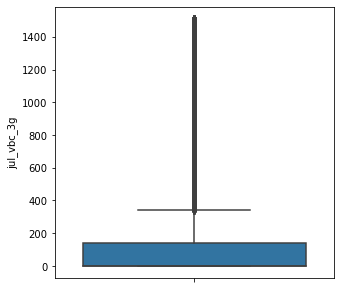

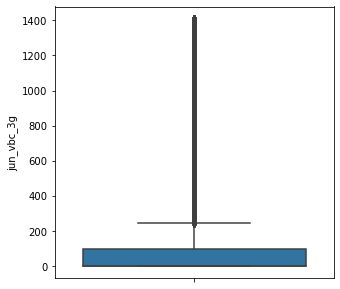

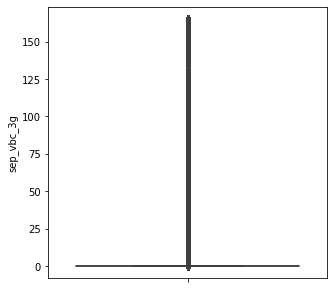

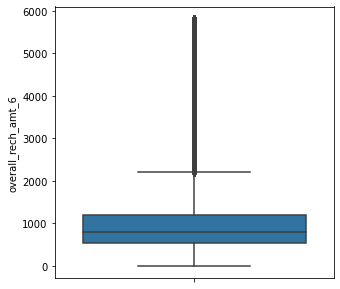

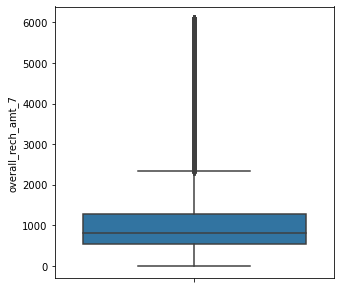

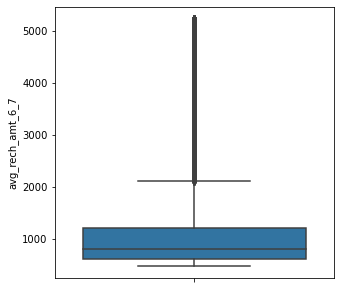

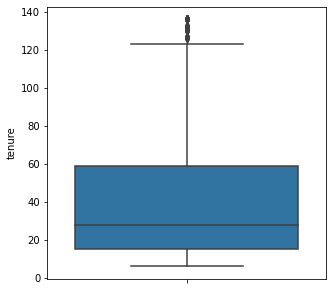

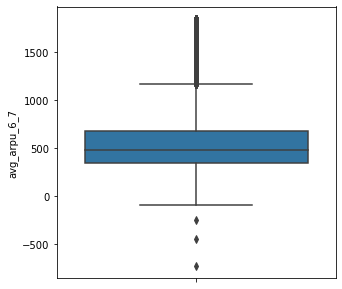

In [75]:
# Again look into box plot as outlier capped or not.
for col in num_vars:
    plt.figure(figsize=(5, 5))
    sns.boxplot(y=col, data=tc)

#### Outlier have been successfully capped for the numerical column.

In [76]:
# Drop mobile no column as is of no use.
tc.drop(['mobile_number'],axis=1, inplace=True)

In [77]:
# Looking for info as mobile number column has dropped or not
tc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 122 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   arpu_8                   float64 
 1   onnet_mou_6              float64 
 2   onnet_mou_7              float64 
 3   onnet_mou_8              float64 
 4   offnet_mou_6             float64 
 5   offnet_mou_7             float64 
 6   offnet_mou_8             float64 
 7   roam_ic_mou_6            float64 
 8   roam_ic_mou_7            float64 
 9   roam_ic_mou_8            float64 
 10  roam_og_mou_6            float64 
 11  roam_og_mou_7            float64 
 12  roam_og_mou_8            float64 
 13  loc_og_t2t_mou_6         float64 
 14  loc_og_t2t_mou_7         float64 
 15  loc_og_t2t_mou_8         float64 
 16  loc_og_t2m_mou_6         float64 
 17  loc_og_t2m_mou_7         float64 
 18  loc_og_t2m_mou_8         float64 
 19  loc_og_t2f_mou_6         float64 
 20  loc_og_t2f_mou_7         fl

#### Mobile no column have been successfully dropped.

### Creating dummy for categorical column. 

In [78]:
# Dummy creation.
dummy = pd.get_dummies(tc[['total_rech_data_group_8','total_rech_num_group_8','tenure_range']], drop_first=True)
dummy.head()


total_rech_data_group_8_<=10_Recharges  \
0   1                                        
7   0                                        
8   1                                        
21  0                                        
23  1                                        

    total_rech_data_group_8_10-25_Recharges  \
0   0                                         
7   0                                         
8   0                                         
21  0                                         
23  0                                         

    total_rech_data_group_8_>25_Recharges  \
0   0                                       
7   0                                       
8   0                                       
21  0                                       
23  0                                       

    total_rech_num_group_8_<=10_Recharges  \
0   1                                       
7   1                                       
8   0                                       
21  0                                       
23  1                                       

    total_rech_num_group_8_10-25_Recharges  \
0   0                                        
7   0                                        
8   1                                        
21  0                                        
23  0                                        

    total_rech_num_group_8_>25_Recharges  tenure_range_6-12 Months  \
0   0                                     0                          
7   0                                     0                          
8   0                                     1                          
21  1                                     0                          
23  0                                     0                          

    tenure_range_1-2 Yrs  tenure_range_2-5 Yrs  tenure_range_5 Yrs and above  
0   0                     1                     0                             
7   0                     1                     0                             
8   0                     0                     0                             
21  1                     0                     0                             
23  1                     0                     0

#### Dummies for the categorical column has been successfully created.

In [79]:
# Adding the results to the main dataframe
tc = pd.concat([tc, dummy], axis=1)
tc.head()

arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   213.803000   53.27        24.613333    0.00         84.23          
7   2014.483901  57.84        54.680000    52.29        453.43         
8   137.362000   413.69       351.030000   35.08        94.66          
21  637.760000   102.41       132.110000   85.14        757.93         
23  366.966000   48.96        50.660000    33.58        85.41          

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0   23.993333     0.00          0.00           0.00           0.00            
7   567.160000    325.91        16.23          33.49          31.64           
8   80.630000     136.48        0.00           0.00           0.00            
21  896.680000    983.39        0.00           0.00           0.00            
23  89.360000     205.89        0.00           0.00           0.00            

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0   0.00           0.00           0.00           53.27              
7   23.74          12.59          38.06          51.39              
8   0.00           0.00           0.00           297.13             
21  0.00           0.00           0.00           4.48               
23  0.00           0.00           0.00           48.96              

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0   24.613333         0.00              79.27             18.196667          
7   31.380000         40.28             308.63            447.380000         
8   217.590000        12.49             80.96             70.580000          
21  6.160000          23.34             91.81             87.930000          
23  50.660000         33.58             82.94             83.010000          

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0   0.00              0.403333          4.813333          0.00               
7   162.28            62.130000         55.140000         53.23              
8   50.54             0.000000          0.000000          0.00               
21  104.81            0.750000          0.000000          1.58               
23  148.56            0.000000          0.000000          0.00               

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0   0.353333          0.0               0.00              132.953333     
7   0.000000          0.0               0.00              422.160000     
8   0.000000          0.0               7.15              378.090000     
21  0.000000          0.0               0.00              97.040000      
23  0.000000          0.0               17.71             131.910000     

    loc_og_mou_7  loc_og_mou_8  std_og_t2m_mou_6  std_og_t2f_mou_6  \
0   47.636667     0.00          0.41              0.00               
7   533.910000    255.79        49.89             6.66               
8   288.180000    63.04         13.69             0.00               
21  94.090000     129.74        665.36            0.00               
23  133.680000    182.14        2.36              0.00               

    std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0   0.00              0.00              0.41          0.976667       
7   20.08             16.68             60.86         75.140000      
8   0.00              0.00              130.26        143.480000     
21  0.00              0.00              763.29        934.690000     
23  0.00              0.00              2.36          6.350000       

    std_og_mou_8  isd_og_mou_6  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0   0.00          0.0           4.14          0.326667      0.00           
7   77.84         0.0           4.50          0.000000      6.50           
8   98.28         0.0           0.00          0.000000      10.23          
21  938.79        0.0           0.00          0.000000      0.00           
23  39.61         0.0           0.10          0.000000      17.71          

    

In [80]:
# Drop those columns from which dummies have been made.
tc.drop(['tenure_range','total_rech_data_group_8','total_rech_num_group_8','sep_vbc_3g','tenure'], axis=1, inplace=True)

In [81]:
# Looking for some data after droping.
tc.head()

arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   213.803000   53.27        24.613333    0.00         84.23          
7   2014.483901  57.84        54.680000    52.29        453.43         
8   137.362000   413.69       351.030000   35.08        94.66          
21  637.760000   102.41       132.110000   85.14        757.93         
23  366.966000   48.96        50.660000    33.58        85.41          

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0   23.993333     0.00          0.00           0.00           0.00            
7   567.160000    325.91        16.23          33.49          31.64           
8   80.630000     136.48        0.00           0.00           0.00            
21  896.680000    983.39        0.00           0.00           0.00            
23  89.360000     205.89        0.00           0.00           0.00            

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0   0.00           0.00           0.00           53.27              
7   23.74          12.59          38.06          51.39              
8   0.00           0.00           0.00           297.13             
21  0.00           0.00           0.00           4.48               
23  0.00           0.00           0.00           48.96              

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0   24.613333         0.00              79.27             18.196667          
7   31.380000         40.28             308.63            447.380000         
8   217.590000        12.49             80.96             70.580000          
21  6.160000          23.34             91.81             87.930000          
23  50.660000         33.58             82.94             83.010000          

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0   0.00              0.403333          4.813333          0.00               
7   162.28            62.130000         55.140000         53.23              
8   50.54             0.000000          0.000000          0.00               
21  104.81            0.750000          0.000000          1.58               
23  148.56            0.000000          0.000000          0.00               

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0   0.353333          0.0               0.00              132.953333     
7   0.000000          0.0               0.00              422.160000     
8   0.000000          0.0               7.15              378.090000     
21  0.000000          0.0               0.00              97.040000      
23  0.000000          0.0               17.71             131.910000     

    loc_og_mou_7  loc_og_mou_8  std_og_t2m_mou_6  std_og_t2f_mou_6  \
0   47.636667     0.00          0.41              0.00               
7   533.910000    255.79        49.89             6.66               
8   288.180000    63.04         13.69             0.00               
21  94.090000     129.74        665.36            0.00               
23  133.680000    182.14        2.36              0.00               

    std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0   0.00              0.00              0.41          0.976667       
7   20.08             16.68             60.86         75.140000      
8   0.00              0.00              130.26        143.480000     
21  0.00              0.00              763.29        934.690000     
23  0.00              0.00              2.36          6.350000       

    std_og_mou_8  isd_og_mou_6  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
0   0.00          0.0           4.14          0.326667      0.00           
7   77.84         0.0           4.50          0.000000      6.50           
8   98.28         0.0           0.00          0.000000      10.23          
21  938.79        0.0           0.00          0.000000      0.00           
23  39.61         0.0           0.10          0.000000      17.71          

    

### segregation of x and y dataset.

In [82]:
# Replacing target variable from x axis.
X = tc.drop(['churn'],axis=1)

In [83]:
# Creating y dataset.
y=tc['churn']

### Spliting data into test and train set.

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (21000, 126)
Dimension of X_test: (9001, 126)


#### After spliting into train and test data set 
#### Train data have 21000 rows and 126 columns
#### Test data have 9001 rows and 126 columns.

In [85]:
# Check for datatype of training set.
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 15709 to 99093
Data columns (total 126 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   arpu_8                                   float64
 1   onnet_mou_6                              float64
 2   onnet_mou_7                              float64
 3   onnet_mou_8                              float64
 4   offnet_mou_6                             float64
 5   offnet_mou_7                             float64
 6   offnet_mou_8                             float64
 7   roam_ic_mou_6                            float64
 8   roam_ic_mou_7                            float64
 9   roam_ic_mou_8                            float64
 10  roam_og_mou_6                            float64
 11  roam_og_mou_7                            float64
 12  roam_og_mou_8                            float64
 13  loc_og_t2t_mou_6                         float64
 14  loc_og_t2t_mou_7 

In [86]:
# seperating numerical column from the data set.
numerical = X_train.select_dtypes(include = ['int64','float64']).columns.tolist()
numerical1=X_test.select_dtypes(include= ['int64','float64']).columns.tolist()

### Scalling.

In [87]:
# Scaling on the dataset.
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical1] = scaler.transform(X_test[numerical1])

### DIMENSIONALITY REDUCTION

## PCA

In [88]:
# Importing the neccessary library.
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)


In [89]:
# PCA on train data set.
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

In [90]:
print(pca.components_)
cnames = list(X_train.columns)

pcac = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':cnames})
pcac.head(10)

[[ 5.79851257e-02  1.26921221e-01  1.35073056e-01 ...  3.20277822e-02
   2.75919966e-02 -7.09796366e-04]
 [ 1.09540661e-01  2.62559697e-02  2.85043938e-02 ... -1.22086868e-01
   2.62831452e-02  1.69367375e-03]
 [ 8.09311462e-02 -1.86287145e-02  6.45139903e-04 ...  4.45933579e-02
   9.80634127e-03 -9.18173078e-04]
 ...
 [ 1.35347260e-03 -2.69985076e-04  1.59724425e-03 ... -4.78605849e-04
  -2.06929261e-04  2.53083206e-03]
 [-2.36967135e-02 -7.18753259e-02  1.33582390e-03 ... -3.73295796e-04
   1.18230837e-04 -3.34642205e-03]
 [ 1.50286418e-02 -2.58092147e-02  4.40589686e-02 ... -3.09132297e-04
  -1.31593040e-04  1.48763332e-03]]


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.057985  0.109541  0.080931  0.109035  0.017559  0.011833 -0.001634   
1  0.126921  0.026256 -0.018629  0.132257  0.035202 -0.061465  0.049484   
2  0.135073  0.028504  0.000645  0.148096  0.036029 -0.066212  0.059009   
3  0.128614  0.038497  0.030600  0.135742  0.035879 -0.056615  0.057063   
4  0.133718  0.106110 -0.017428  0.108350 -0.003407 -0.015230  0.039338   
5  0.140563  0.107578  0.006006  0.121374  0.002919 -0.014828  0.049802   
6  0.131329  0.118759  0.042971  0.109237  0.003065 -0.010017  0.044988   
7  0.008204  0.008407 -0.004904  0.034478  0.016210  0.011552 -0.022259   
8  0.003229  0.002713 -0.010825  0.029531  0.011489  0.015195 -0.022245   
9  0.007200  0.005791 -0.005914  0.032309  0.013928  0.006578 -0.013247   

        PC8       PC9      PC10        Feature  
0 -0.007765 -0.000754 -0.008309  arpu_8         
1  0.115813 -0.215001  0.233128  onnet_mou_6    
2  0.105374 -0.240057  0.262210  onnet_mou_7    
3  0.069971 -0.231373  0.239546  onnet_mou_8    
4  0.011752  0.176262 -0.291179  offnet_mou_6   
5 -0.013690  0.156189 -0.267091  offnet_mou_7   
6 -0.043690  0.116178 -0.223742  offnet_mou_8   
7 -0.080092  0.029259  0.054702  roam_ic_mou_6  
8 -0.064124  0.032704  0.037271  roam_ic_mou_7  
9 -0.063077  0.033787  0.032156  roam_ic_mou_8

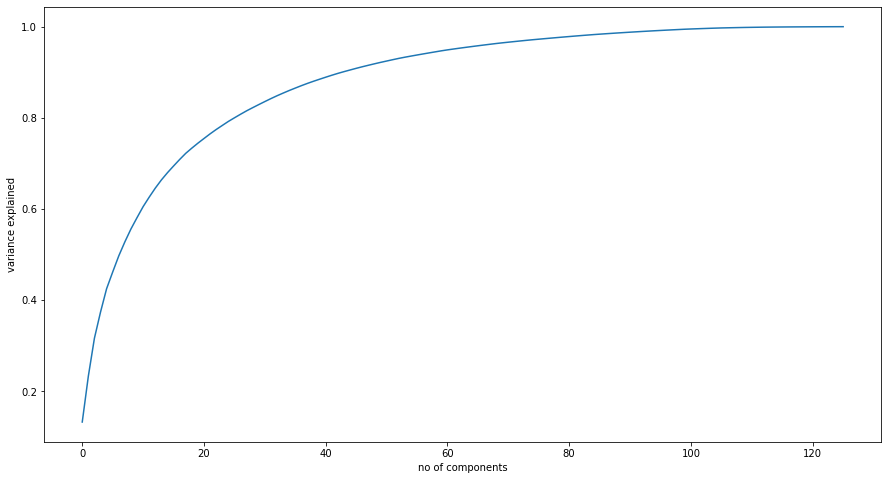

In [91]:
# Draw graph between no of components and variance explained
# On the basis of this graph will able to take no of components.
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of components')
plt.ylabel('variance explained')
plt.show()

#### As 60 components are able to explain more than 90 percent of the data variance.

In [92]:
# We will choose 60 components and move further.
from sklearn.decomposition import IncrementalPCA
pca60 = IncrementalPCA(n_components=60)

train60 = pca60.fit_transform(X_train)
train60.shape

(21000, 60)

### Make correlation matrix for the defined no of components.

<AxesSubplot:>

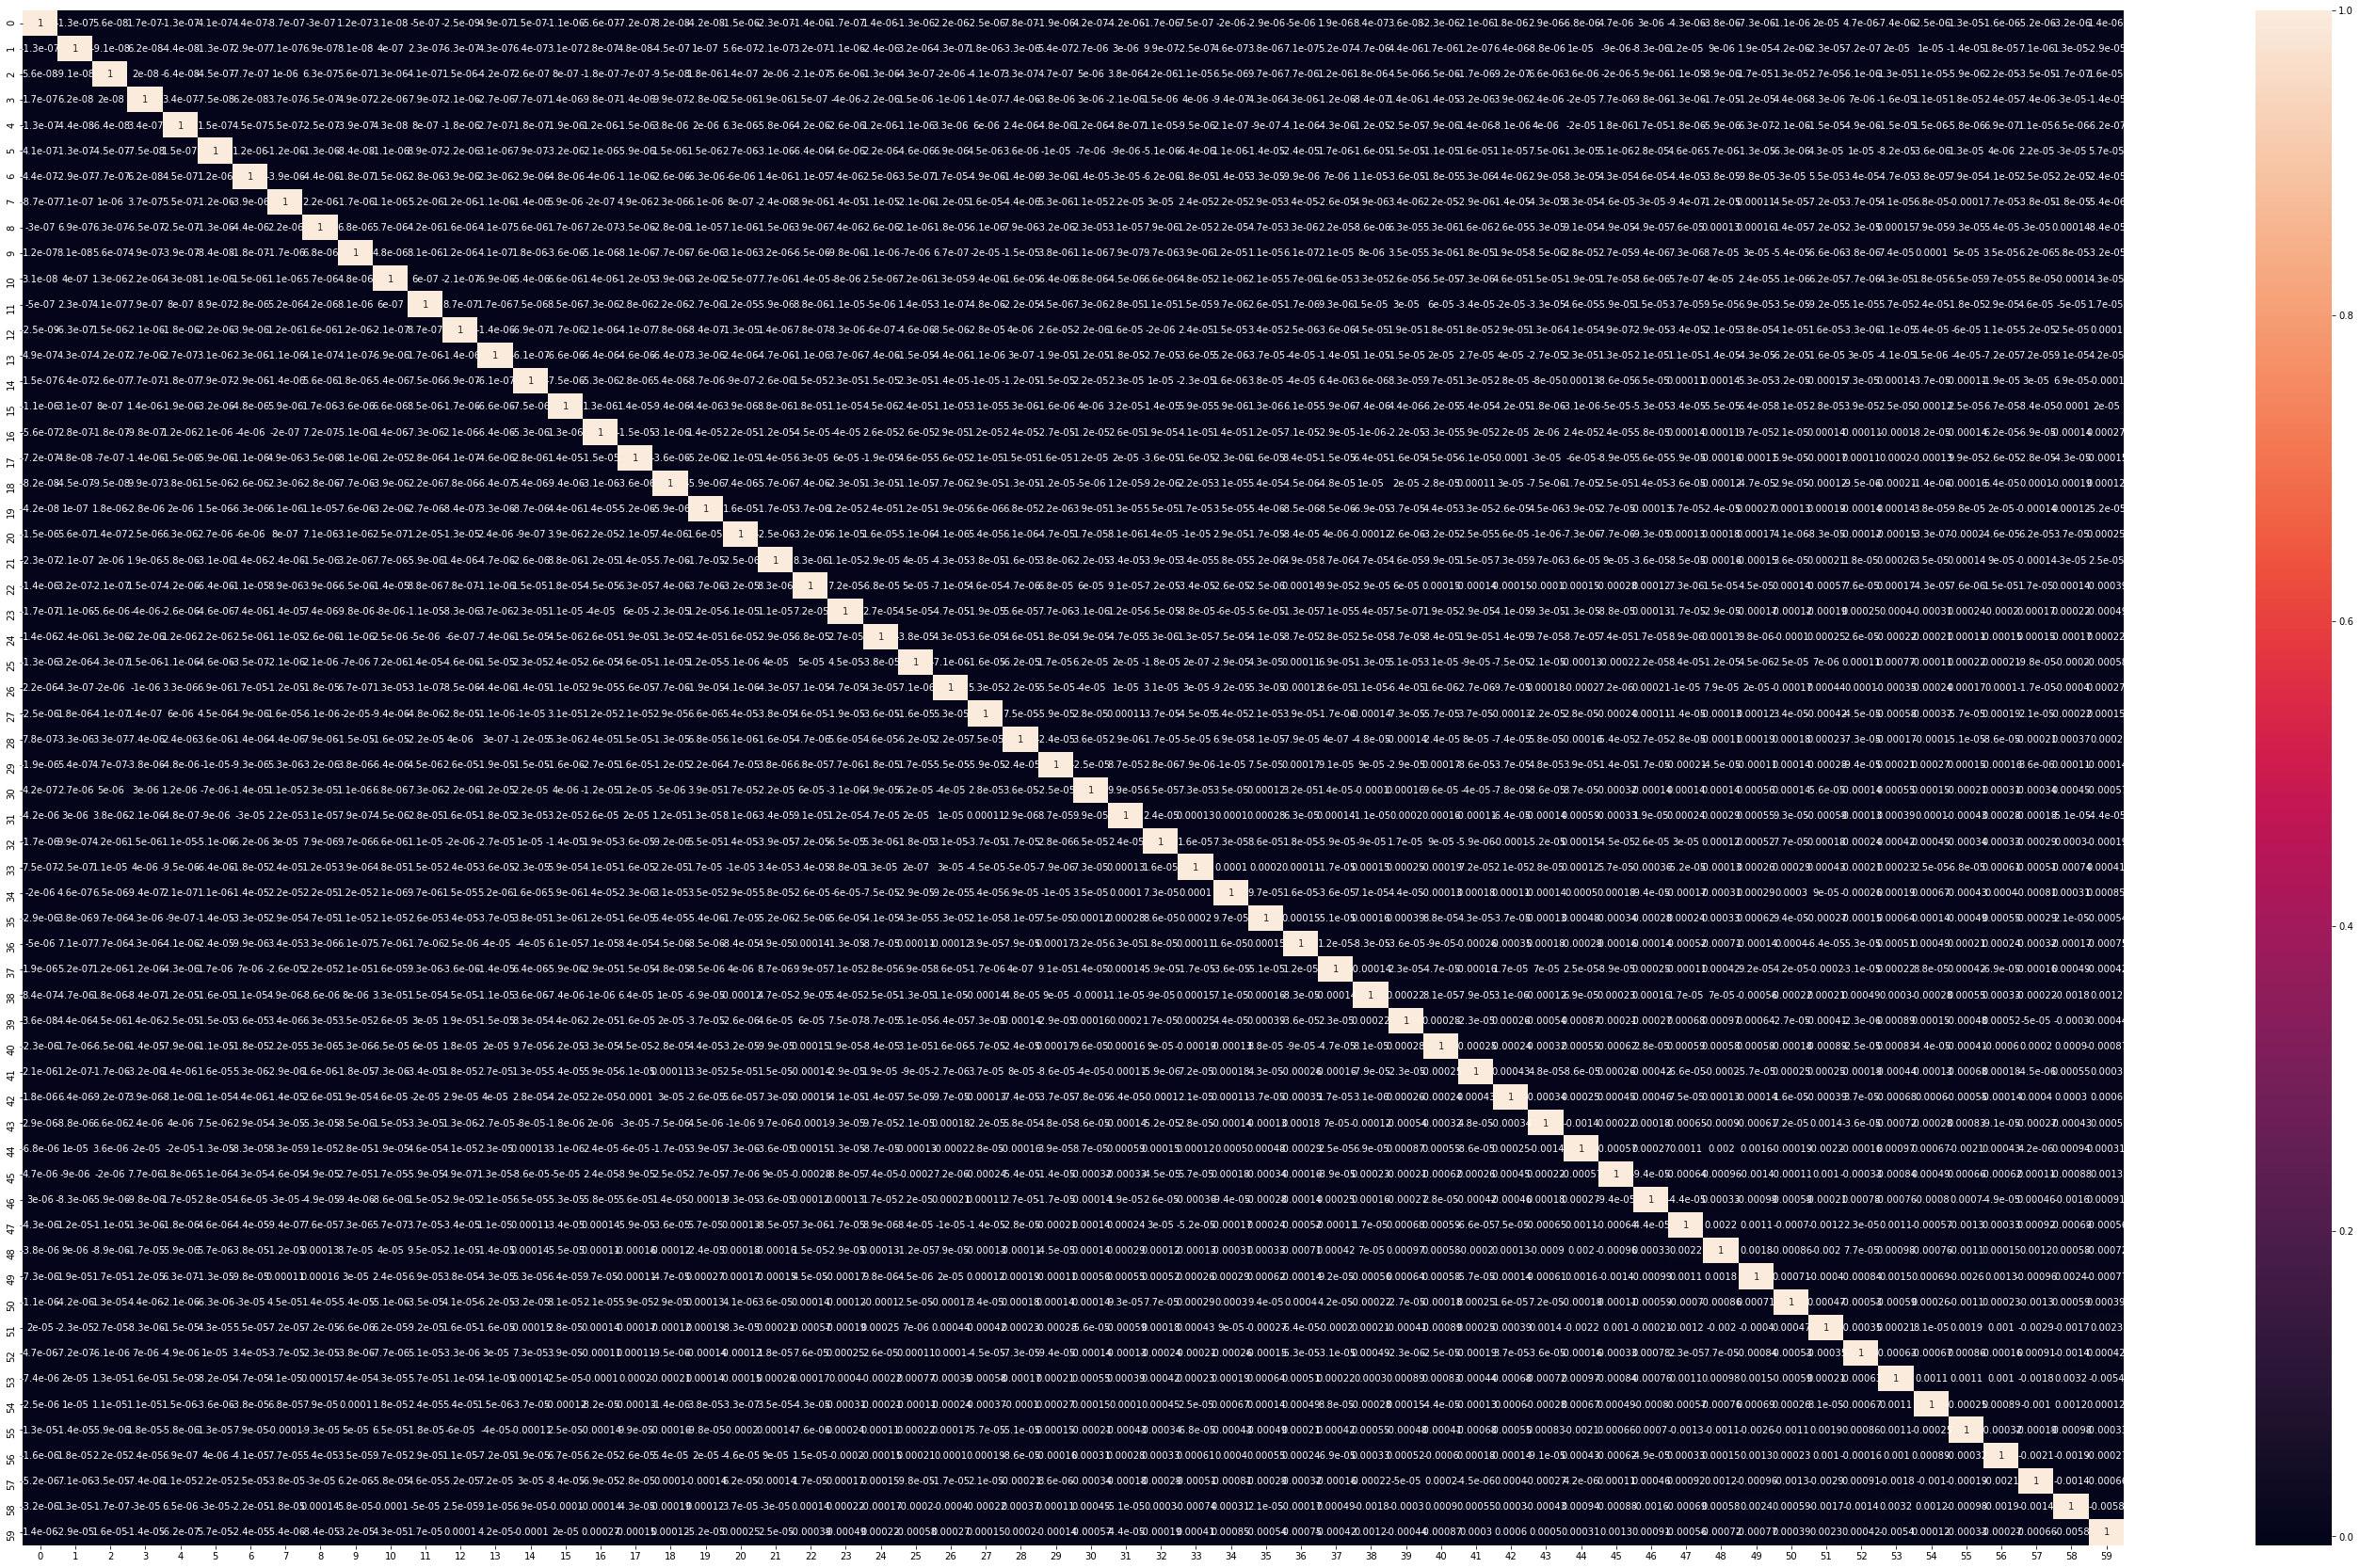

In [93]:
# Making correlation matrix.
corr = np.corrcoef(train60.transpose())
# Plotting heatmap.
%matplotlib inline
plt.figure(figsize = (50,30))
sns.heatmap(corr,annot = True)

#### By the visual interpretation we can conclude that pca components are not highly correlated with each other.
#### For further confimation find the lowest and highest correlation cofficient.

In [94]:
# Finding the lowest and highest correlation coefficient.
corrmat = corr - np.diagflat(corr.diagonal())
print("max corr:",corrmat.max(), ", min corr: ", corrmat.min(),)

max corr: 0.003174059790983222 , min corr:  -0.0058015504095908325


#### Now it is clear that no variables is that highly correlated with each other.

In [95]:
# Applying pca on the testset.
test60 = pca60.transform(X_test)
test60.shape

(9001, 60)

#### Test data et contains 9001 rows and 60 columns.

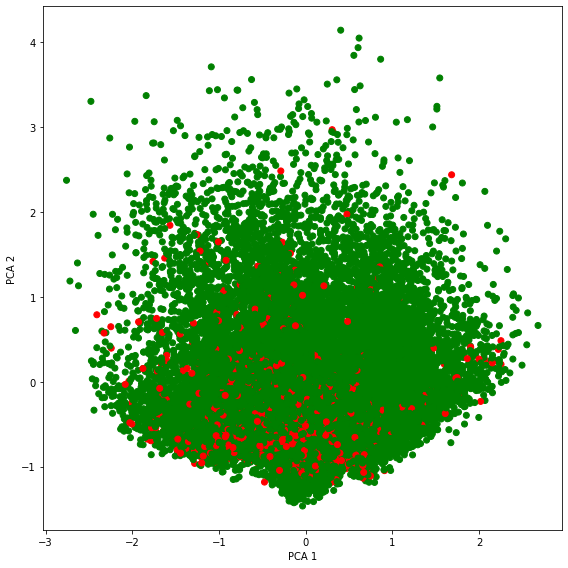

In [96]:
# Look for some visualisation between pca1 and pca2.
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(train60[:,0], train60[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

## MODEL BUILDING

## Logistic regression with PCA.

In [97]:
# importing neccessary libraries.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# Train the model o train dataset.
learner = LogisticRegression()
lpca = learner.fit(train60,y_train)

#### Now make predictions on test data set.

In [98]:
testp = lpca.predict_proba(test60)
default = lpca.predict(test60)

In [99]:
default

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
# Classification report.
print(confusion_matrix(y_test,default))
print(accuracy_score(y_test,default))

[[8166  106]
 [ 557  172]]
0.9263415176091545


#### Accuracy on test set is 92.6%.

In [101]:
accuracy_score(y_train,lpca.predict(train60))

0.9270952380952381

#### Accuracy on train data set is 92.7%. From this we can conclude that our model is good.

In [102]:
preddf = pd.DataFrame(testp)
# Converting to column dataframe
pred1 = preddf.iloc[:,[1]]

# Removing index for both dataframes 
pred1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending
predfinal = pd.concat([y_test,pred1],axis=1)

# Renaming the column 
predfinal= predfinal.rename(columns={ 1 : 'churn_prob'})

In [103]:
# finding roc score.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(predfinal.churn,predfinal.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.880179686277007


#### Roc- Auc score is approx 88%.

## ROC curve.

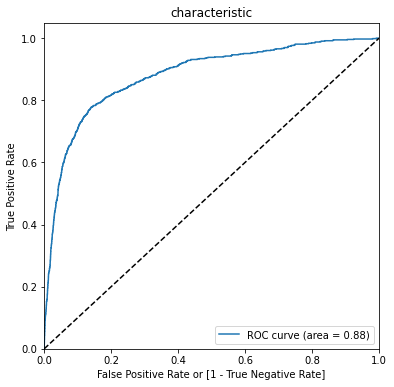

(array([0.        , 0.        , 0.        , ..., 0.99975822, 0.99987911,
        1.        ]),
 array([0.        , 0.00137174, 0.00274348, ..., 1.        , 1.        ,
        1.        ]),
 array([1.95103827e+00, 9.51038271e-01, 9.12902809e-01, ...,
        6.14907333e-06, 5.14821218e-06, 4.92927665e-06]))

In [104]:
# Making ROC curve.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds
# Draw Roc curve.

draw_roc(predfinal.churn, predfinal.churn_prob)

#### It can be seen that area under roc curve is 76% which looks fine and we procced further.

### Creating probability cut-offs

In [105]:
# Creating columns for different probabilities cut offs.
num = [float(x)/10 for x in range(10)]
for i in num:
    predfinal[i]= predfinal.churn_prob.map( lambda x: 1 if x > i else 0)
predfinal.head(10)

churn  churn_prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0  0      0.288672    1    1    1    0    0    0    0    0    0    0  
1  0      0.051720    1    0    0    0    0    0    0    0    0    0  
2  0      0.000481    1    0    0    0    0    0    0    0    0    0  
3  0      0.012931    1    0    0    0    0    0    0    0    0    0  
4  0      0.002063    1    0    0    0    0    0    0    0    0    0  
5  0      0.039013    1    0    0    0    0    0    0    0    0    0  
6  0      0.000757    1    0    0    0    0    0    0    0    0    0  
7  1      0.210772    1    1    1    0    0    0    0    0    0    0  
8  0      0.069791    1    0    0    0    0    0    0    0    0    0  
9  0      0.159494    1    1    0    0    0    0    0    0    0    0

In [106]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff = pd.DataFrame( columns = ['prob','accuracy','sensivity','specificity'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm = metrics.confusion_matrix( predfinal.churn, predfinal[i] )
    total1=sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total1
    sensivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff.loc[i] =[ i ,accuracy,sensivity,specificity]
print(cutoff)

     prob  accuracy  sensivity  specificity
0.0  0.0   0.080991  0.000000   1.000000   
0.1  0.1   0.836352  0.840546   0.788752   
0.2  0.2   0.901011  0.922631   0.655693   
0.3  0.3   0.920564  0.953941   0.541838   
0.4  0.4   0.926230  0.972921   0.396433   
0.5  0.5   0.926342  0.987186   0.235940   
0.6  0.6   0.924120  0.994318   0.127572   
0.7  0.7   0.922231  0.998187   0.060357   
0.8  0.8   0.920342  0.999516   0.021948   
0.9  0.9   0.919453  1.000000   0.005487   


#### From this we can conclude that our cut-off point is in between 0.1 and 0.2.

<AxesSubplot:xlabel='prob'>

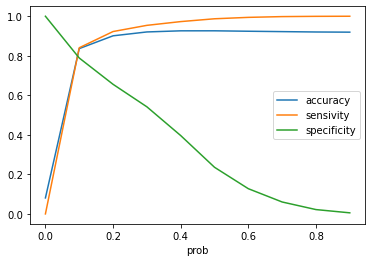

In [107]:
# Plotting accuracy,senstiviy,specificity.
cutoff.plot.line(x='prob', y=['accuracy','sensivity','specificity'])

In [108]:
# Finding optimal cuttoff for above process.
import sys
def Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Finding optima threshold probability 
threshold = Optimal_Cutoff(predfinal.churn,predfinal.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.08453105356573491]


In [109]:
# Finding values of 0 and 1 for optimal threshold
predfinal['pred_churn'] = predfinal.churn_prob.map( lambda x: 1 if x > 0.084 else 0)

predfinal.churn.value_counts()

0    8272
1    729 
Name: churn, dtype: int64

#### Predicted churn is 729 and non-churn is 8272.
#### Churn percentage is very low as compared to non-churn.

## Make confusion matrix.

In [110]:
con = metrics.confusion_matrix( predfinal.churn, predfinal.pred_churn )
con

array([[6695, 1577],
       [ 137,  592]], dtype=int64)

#### Confusion matrix is successfully made.

### Insight of logistic regression model with PCA.

In [111]:
TP = con[1,1] # true positive 
TN = con[0,0] # true negatives
FP = con[0,1] # false positives
FN = con[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.9263415176091545
Sensitivity:  0.8120713305898491
Specificity:  0.8093568665377177
false postive rate:  0.1906431334622824
positive predictive value:  0.2729368372521899
Negative predictive value:  0.979947306791569
Misclassification Rate:  0.19042328630152205


#### As we can see some insight like accuracy on the test set is 92%, Misclassification error is 0.19%.
#### These insights are looking preity good.

## Logistic regression with RFE.

In [112]:
# Importing neccessary libraries.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)            
rfe = rfe.fit(X_train,y_train)
print(rfe.support_)          
print(rfe.ranking_)          

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False  True False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False  True
 False False False False False False False False  True False False False
 False False  True  True False False  True False False False  True False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
[ 27  48  81  24  57  47  25  95  29  86 103  89   3  58  21 102  92   8
  32  74   4  15  79  90  55  12   7  26  59 107 111  20  11  46   1  14
 116 109  73  71  60  31  10  28   1  88  65   9  49   6   5 104  67  56
  87 110   1 

In [113]:
# Visulising the column abstracting from Rfe.
column = X_train.columns[rfe.support_]
column

Index(['std_og_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8', 'vol_2g_mb_8', 'avg_arpu_6_7'],
      dtype='object')

### Top 10 columns taken by RFE are.
#### std_og_mou_8
#### total_og_mou_8
#### loc_ic_mou_8
#### spl_ic_mou_8
#### total_rech_num_8
#### last_day_rch_amt_8
#### total_rech_data_8
#### max_rech_data_8
#### vol_2g_mb_8
#### avg_arpu_6_7

In [114]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### Building Correlation matrix.

<AxesSubplot:>

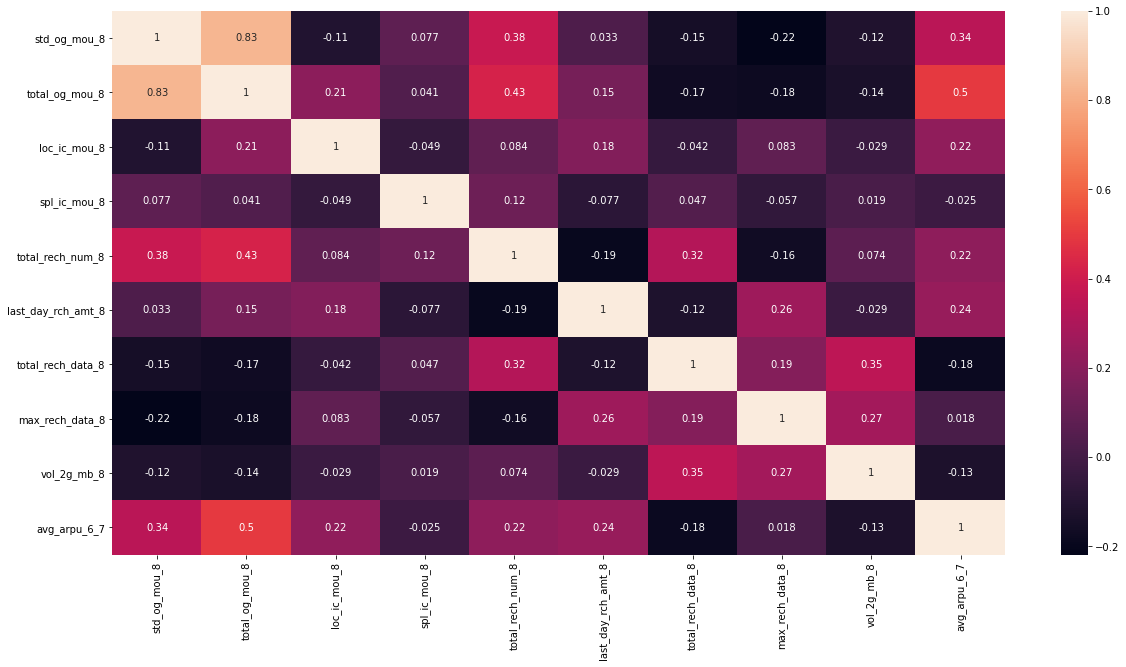

In [115]:
# Looking for correlation matrix.
plt.figure(figsize = (20,10))        
sns.heatmap(X_train[column].corr(),annot = True)

#### From the above correlation matrix it can be seen that std_og_mou_8 and total_og_mou_8 variable are highly correlated.



## Checking VIF Values of the columns selected by RFE.

In [116]:
# VIF check.
vifc = list(column)
vifc.append('churn')
# head()
vif_cal(input_data=tc[vifc], dependent_col='churn')

Var   Vif
1  total_og_mou_8      9.40
0  std_og_mou_8        5.97
9  avg_arpu_6_7        4.24
4  total_rech_num_8    3.86
2  loc_ic_mou_8        2.51
5  last_day_rch_amt_8  2.07
6  total_rech_data_8   2.03
7  max_rech_data_8     1.90
8  vol_2g_mb_8         1.42
3  spl_ic_mou_8        1.10

#### Vif for all attributes are under range.

In [117]:
# Fitting the model.
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
sk = LogisticRegression(class_weight='balanced')
sk.fit(X_train[column], y_train)

LogisticRegression(class_weight='balanced')

In [118]:
# prediction on the test data set
testp = sk.predict_proba(X_test[column])
default = sk.predict(X_test[column])

In [119]:
# Printing accuracy score.
print('accuracy_score : ',accuracy_score(y_test,default))

accuracy_score :  0.7986890345517165


#### We obtained accuracy of approx 80%.

In [120]:
preddf = pd.DataFrame(testp)
# Converting to column dataframe
pred1 = preddf.iloc[:,[1]]

# Removing index for both dataframes 
pred1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending
predfinal = pd.concat([y_test,pred1],axis=1)

# Renaming the column 
predfinal= predfinal.rename(columns={ 1 : 'churn_prob'})

In [121]:
# finding roc score.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(predfinal.churn,predfinal.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8735383782665106


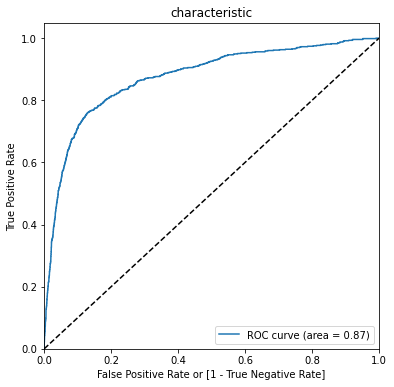

(array([0.        , 0.        , 0.        , ..., 0.99975822, 0.99987911,
        1.        ]),
 array([0.        , 0.00137174, 0.00274348, ..., 1.        , 1.        ,
        1.        ]),
 array([1.99833180e+00, 9.98331796e-01, 9.97367421e-01, ...,
        1.44103936e-05, 1.41629350e-05, 1.07955081e-05]))

In [122]:
# Plotting roc curve.
draw_roc(predfinal.churn, predfinal.churn_prob)

In [123]:
# Creating columns for different probabilities cut offs.
num = [float(x)/10 for x in range(10)]
for i in num:
    predfinal[i]= predfinal.churn_prob.map( lambda x: 1 if x > i else 0)
predfinal.head(10)

churn  churn_prob  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0  0      0.775924    1    1    1    1    1    1    1    1    0    0  
1  0      0.451812    1    1    1    1    1    0    0    0    0    0  
2  0      0.004393    1    0    0    0    0    0    0    0    0    0  
3  0      0.320457    1    1    1    1    0    0    0    0    0    0  
4  0      0.019030    1    0    0    0    0    0    0    0    0    0  
5  0      0.157175    1    1    0    0    0    0    0    0    0    0  
6  0      0.012776    1    0    0    0    0    0    0    0    0    0  
7  1      0.861066    1    1    1    1    1    1    1    1    1    0  
8  0      0.845593    1    1    1    1    1    1    1    1    1    0  
9  0      0.496002    1    1    1    1    1    0    0    0    0    0

In [124]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff = pd.DataFrame( columns = ['prob','accuracy','sensivity','specificity'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm = metrics.confusion_matrix( predfinal.churn, predfinal[i] )
    total1=sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total1
    sensivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    cutoff.loc[i] =[ i ,accuracy,sensivity,specificity]
print(cutoff)

     prob  accuracy  sensivity  specificity
0.0  0.0   0.080991  0.000000   1.000000   
0.1  0.1   0.365848  0.313346   0.961591   
0.2  0.2   0.524164  0.488395   0.930041   
0.3  0.3   0.642151  0.620164   0.891632   
0.4  0.4   0.727253  0.715184   0.864198   
0.5  0.5   0.798689  0.797268   0.814815   
0.6  0.6   0.850683  0.858075   0.766804   
0.7  0.7   0.891123  0.908849   0.689986   
0.8  0.8   0.919231  0.954425   0.519890   
0.9  0.9   0.924564  0.988878   0.194787   


#### It can be seen that optimal cuoff is 0.5.

<AxesSubplot:xlabel='prob'>

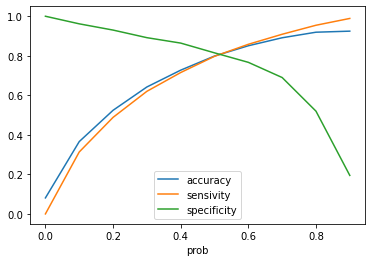

In [125]:
# Plotting accuracy,senstiviy,specificity.
cutoff.plot.line(x='prob', y=['accuracy','sensivity','specificity'])

In [126]:
# Finding optimal cuttoff for above process.
import sys
def Optimal_Cutoff(target, predicted):

    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

# Finding optima threshold probability 
threshold = Optimal_Cutoff(predfinal.churn,predfinal.churn_prob)
print('Threshold: ',threshold)

Threshold:  [0.5100562640173768]


In [127]:
# Finding values of 0 and 1 for optimal threshold
predfinal['pred_churn'] = predfinal.churn_prob.map( lambda x: 1 if x > 0.084 else 0)

predfinal.churn.value_counts()

0    8272
1    729 
Name: churn, dtype: int64

#### There are 8727 values for non-churn and 729 values for churn.


## Make confusion matrix.

In [128]:
con = metrics.confusion_matrix( predfinal.churn, predfinal.pred_churn )
con

array([[2307, 5965],
       [  26,  703]], dtype=int64)

### Insight of logistic regression model with RFE.

In [129]:

TP = con[1,1] # true positive 
TN = con[0,0] # true negatives
FP = con[0,1] # false positives
FN = con[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.7986890345517165
Sensitivity:  0.9643347050754458
Specificity:  0.2788926499032882
false postive rate:  0.7211073500967118
positive predictive value:  0.10542891421715657
Negative predictive value:  0.9888555507929704
Misclassification Rate:  0.6655927119208976


### Important insights of logistic regression with RFE.
#### Accuracy score =81%.

### Comparison of the models.
#### Logistic regression with PCA.
- Accuracy Score on test data:  0.9263415176091545
- Sensitivity:  0.8120713305898491
- Specificity:  0.8093568665377177
- false postive rate:  0.1906431334622824
- sitive predictive value:  0.2729368372521899
- gative predictive value:  0.979947306791569
- sclassification Rate:  0.19042328630152205
#### Logistic regression with RFE.
- Accuracy Score on test data:  0.7986890345517165
- Sensitivity:  0.9643347050754458
- Specificity:  0.2788926499032882
- false postive rate:  0.7211073500967118
- positive predictive value:  0.10542891421715657
- Negative predictive value:  0.9888555507929704
- Misclassification Rate:  0.6655927119208976

 




## Decision tree with PCA.

In [130]:
# Imporing decision tree classifier library.
from sklearn.tree import DecisionTreeClassifier

# Make decision tree with depth=5.
dt1 = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
dt1.fit(train60,y_train)


DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [131]:
# Making predictions on test data set.
default1 = dt1.predict(test60)


# Print classification report, confusion matrix, accuracy score
print(classification_report(y_test,default))
print(confusion_matrix(y_test,default))
print('Accuracy Score', accuracy_score(y_test,default))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      8272
           1       0.26      0.81      0.40       729

    accuracy                           0.80      9001
   macro avg       0.62      0.81      0.64      9001
weighted avg       0.92      0.80      0.84      9001

[[6595 1677]
 [ 135  594]]
Accuracy Score 0.7986890345517165


#### Accuracy score for test data set is approximately 80%.

### Make confusion matrix and find result when no hyperparameter tunning done. 

In [132]:
confusion_tree = confusion_matrix(y_test,default1)
TP = confusion_tree[1,1] # true positive 
TN = confusion_tree[0,0] # true negatives
FP = confusion_tree[0,1] # false positives
FN = confusion_tree[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.7986890345517165
Sensitivity:  0.6694101508916324
Specificity:  0.8227756286266924
false postive rate:  0.17722437137330754
positive predictive value:  0.24974411463664278
Negative predictive value:  0.9658010500922378
Misclassification Rate:  0.18964559493389624


## Hyperparameter tunning for decision tree.

In [133]:
# Importing library for grid search.
from sklearn.model_selection import GridSearchCV

In [134]:
# Define parameters from which grid search find the optimal value
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}

In [135]:
dt = DecisionTreeClassifier(random_state=42)

In [136]:
# apply grid search on different parameters.
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [137]:
# Fitting the result of grid search on pca components of train data set.
grid_search.fit(train60, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             scoring='accuracy', verbose=1)

In [138]:
# Finding the best score
grid_search.best_score_

0.918952380952381

In [139]:
# finding the optimal parameters.
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)

In [140]:
# making decision tree with the obtained parameters and fits the model. 
dt2 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42, class_weight='balanced')
dt2.fit(train60,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=5,
                       random_state=42)

In [141]:
# Make predictions on test data set.
default2 = dt2.predict(test60)

In [142]:
# Make confusion matrix for the model.
confusion = confusion_matrix(y_test,default2)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.7986890345517165
Sensitivity:  0.6748971193415638
Specificity:  0.8093568665377177
false postive rate:  0.1906431334622824
positive predictive value:  0.23779603673272112
Negative predictive value:  0.9658107328332372
Misclassification Rate:  0.2015331629818909


## Random forest with PCA.

#### First make random forest model without hyperparameter tunning.

In [143]:
# Importig neccessarylibrary for random forest.
from sklearn.ensemble import RandomForestClassifier

In [144]:
# Initialise randon forest classifier.
rf = RandomForestClassifier(class_weight='balanced')

# fit the model o PCA components.
rf.fit(train60,y_train)

# Make preditions on test data set.
default = rf.predict(test60)

In [145]:
# Make confusion matrix for random forest model.
conrf=confusion_matrix(y_test,default)
conrf

array([[8209,   63],
       [ 648,   81]], dtype=int64)

In [146]:
TP = conrf[1,1] # true positive 
TN = conrf[0,0] # true negatives
FP = conrf[0,1] # false positives
FN = conrf[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.9210087768025775
Sensitivity:  0.1111111111111111
Specificity:  0.9923839458413927
false postive rate:  0.00761605415860735
positive predictive value:  0.5625
Negative predictive value:  0.9268375296375748
Misclassification Rate:  0.07899122319742251


#### Accuracy by random forest model without hypertunning comes out to be pretty good.
#### Sensitivity obtained is very low.

### Hyperparameter tunning of random forest.

In [147]:
# Defining the decision classifier.
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [148]:
# Defining the parameters.
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [149]:
# Finding the optimal parameer through grid search.
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [150]:
# Fitting on the train set obtained after PCA.
grid_search.fit(train60, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [151]:
# Finding the beat score.
grid_search.best_score_

0.923

In [152]:
# finding the optimal values of parameters.
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=10,
                       n_jobs=-1, random_state=42)

#### Above are the best parameters for making random forest.

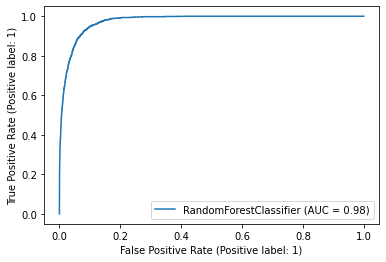

In [153]:
# Importing library for lotting roc curve.
from sklearn.metrics import plot_roc_curve
# Plotting roc curve.
plot_roc_curve(rf_best, train60, y_train)
plt.show()

In [154]:
# Make a random forest model with desired hyperparameter tunning.
rf = RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=10,
                       n_jobs=-1, random_state=42,class_weight='balanced')
# Fitting the model.
rf.fit(train60,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=10, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [155]:
# Make preditions on test data set.
default = rf.predict(test60)

In [156]:
# Define confusion matrix.
conrf=confusion_matrix(y_test,default)
conrf

array([[7788,  484],
       [ 361,  368]], dtype=int64)

In [157]:
TP = conrf[1,1] # true positive 
TN = conrf[0,0] # true negatives
FP = conrf[0,1] # false positives
FN = conrf[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,default))

# sensitivity for our model
print('Sensitivity: ', TP / float(TP+FN))

# Specificity for our model
print('Specificity: ',TN / float(TN+FP))

#False positive rate for our model. 
print('false postive rate: ',FP/ float(TN+FP))

# Positive predictive value for our model.
print('positive predictive value: ', TP / float(TP+FP))

# Negative predective value for our model.
print('Negative predictive value: ',TN / float(TN+ FN))

# Misclassification rate for or model.

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.9061215420508832
Sensitivity:  0.50480109739369
Specificity:  0.9414893617021277
false postive rate:  0.05851063829787234
positive predictive value:  0.431924882629108
Negative predictive value:  0.9557000859001105
Misclassification Rate:  0.09387845794911677


#### <span style='color:green'> As we can see above that sensivity improves drastically when hyperparameter tunning is done.

## <span style='color:red'>Comparison of DECISION TREE(PCA) and RANDOM FOREST(PCA).</span>

### INSIGHTS OF DECISION TREE(PCA)
#### Without hyperparameter tunning.
- <span style='color:Green '> Accuracy Score on test data:  0.7986890345517165</span>
- <span style='color:Green '> Sensitivity:  0.6694101508916324</span>
- <span style='color:blue '> Specificity:  0.8227756286266924</span>
- <span style='color:blue '> false postive rate:  0.17722437137330754</span>
- <span style='color:blue '> positive predictive value:  0.24974411463664278</span>
- <span style='color:blue '> Negative predictive value:  0.9658010500922378</span>
- <span style='color:blue '>Misclassification Rate:  0.18964559493389624</span>
#### With hyperparameter tunning.
- <span style='color:green '> Accuracy Score on test data:  0.7986890345517165</span>
- <span style='color:green '> Sensitivity:  0.6748971193415638</span>
- <span style='color:blue '> Specificity:  0.8093568665377177</span>
- <span style='color:blue '> false postive rate:  0.1906431334622824</span>
- <span style='color:blue '> positive predictive value:  0.23779603673272112</span>
- <span style='color:blue '> Negative predictive value:  0.9658107328332372</span>
- <span style='color:blue '> Misclassification Rate:  0.2015331629818909</span>
### INSIGHTS OF RANDOM FOREST(PCA)
#### Without hyperparameter tunning .
- <span style='color:green '> Accuracy Score on test data:  0.9186757026997</span>
- <span style='color:green '> Sensitivity:  0.08641975308641975</span>
- <span style='color:blue '> Specificity:  0.9920212765957447</span>
- <span style='color:blue '> false postive rate:  0.007978723404255319</span>
- <span style='color:blue '> positive predictive value:  0.4883720930232558</span>
- <span style='color:blue '> Negative predictive value:  0.9249323715058612</span>
- <span style='color:blue '> Misclassification Rate:  0.08132429730029997</span>
#### With hyperparameter tunning.
- <span style='color:green '> Accuracy Score on test data:  0.9061215420508832</span>
- <span style='color:green '> Sensitivity:  0.50480109739369</span>
- <span style='color:blue '> Specificity:  0.9414893617021277</span>
- <span style='color:blue '> false postive rate:  0.05851063829787234</span>
- <span style='color:blue '>positive predictive value:  0.431924882629108</span>
- <span style='color:blue '>Negative predictive value:  0.9557000859001105</span>
- <span style='color:blue '>Misclassification Rate:  0.09387845794911677</span>




### <span style='color:red'>Conclusion for random forest model and decision tree model.</span>
#### <span style='color:green'>1. For decision tree with hyperparameter tunning there is slight increase in accuracy and sensitivity of the model.</span>
#### <span style='color:green'>2. For random forest model when hyperparametertunning is done there is drastically increase in the sensitivity of the model</span>


#### Definition of sensitivity.
- It defines that how good you are predicting the actual (churn) values. 
#### <span style='color:green'>For this case study sensitivity is the key factor for finding the actual churn customers.</span>


### So, we take hyperparameter tunned model for decision tree as well as random forest.

## All models comparison.

### Insights of Logistic Regression(PCA).
- <span style='color:green'>Accuracy Score on test data:  0.9263415176091545</span>
- <span style='color:green'>Sensitivity:  0.8120713305898491</span>
- <span style='color:blue'>Specificity:  0.8093568665377177</span>
- <span style='color:blue'>false postive rate:  0.1906431334622824</span>
- <span style='color:blue'>positive predictive value:  0.2729368372521899</span>
- <span style='color:blue'>Negative predictive value:  0.979947306791569</span>
- <span style='color:blue'>Misclassification Rate:  0.19042328630152205</span>
### Insights of Logistic Regression(RFE)
- <span style='color:green'>Accuracy Score on test data:  0.7986890345517165</span>
- <span style='color:green'>Sensitivity:  0.9643347050754458</span>
- <span style='color:blue'>Specificity:  0.2788926499032882</span>
- <span style='color:blue'>false postive rate:  0.7211073500967118</span>
- <span style='color:blue'>positive predictive value:  0.10542891421715657</span>
- <span style='color:blue'>Negative predictive value:  0.9888555507929704</span>
- <span style='color:blue'>Misclassification Rate:  0.6655927119208976</span>
### Insights of Decision Tree(PCA)
- <span style='color:green'>Accuracy Score on test data: 0.7986890345517165</span>
- <span style='color:green'>Sensitivity: 0.6748971193415638</span>
- <span style='color:blue'>Specificity: 0.8093568665377177</span>
- <span style='color:blue'>false postive rate: 0.1906431334622824</span>
- <span style='color:blue'>positive predictive value: 0.23779603673272112</span>
- <span style='color:blue'>Negative predictive value: 0.9658107328332372</span>
- <span style='color:blue'>Misclassification Rate: 0.2015331629818909</span>
### Insights of Random Forest(PCA)
- <span style='color:green'>Accuracy Score on test data: 0.9061215420508832</span>
- <span style='color:green'>Sensitivity: 0.50480109739369</span>
- <span style='color:blue'>Specificity: 0.9414893617021277</span>
- <span style='color:blue'>false postive rate: 0.05851063829787234</span>
- <span style='color:blue'>positive predictive value: 0.431924882629108</span>
- <span style='color:blue'>Negative predictive value: 0.9557000859001105</span>
- <span style='color:blue'>Misclassification Rate: 0.09387845794911677</span>





### Best model on the basis of accuracy.
- <span style='color:green'>Logistic Regression(PCA).</span>
### Best model on the basis of sensitivity.
- <span style='color:green'>Logistic Regression(RFE).</span>

### <span style='color:green'>Top 10 variables which is responsible for deciding churn and non-churn are.</span>
- <span style='color:green'>std_og_mou_8</span>
- <span style='color:green'>total_og_mou_8</span>
- <span style='color:green'>loc_ic_mou_8</span>
- <span style='color:green'>spl_ic_mou_8</span>
- <span style='color:green'>total_rech_num_8</span>
- <span style='color:green'>last_day_rch_amt_8</span>
- <span style='color:green'>total_rech_data_8</span>
- <span style='color:green'>max_rech_data_8</span>
- <span style='color:green'>vol_2g_mb_8</span>
- <span style='color:green'>avg_arpu_6_7</span>